In [69]:
import geopandas as gpd
import folium

# Leer el archivo GeoJSON
geojson_path = 'datos/Major_Ocean_Currents.geojson'
gdf = gpd.read_file(geojson_path)

# Crear un mapa centrado en un punto geográfico central del conjunto de datos
m = folium.Map(location=[0, 0], zoom_start=2)

# Añadir los datos GeoJSON al mapa
folium.GeoJson(gdf).add_to(m)
m

In [48]:
import geopandas as gpd
from shapely.geometry import shape, mapping
import pandas as pd
import json
import h5netcdf
import matplotlib.pyplot as plt

# Define the buffer distance (e.g., 1 degree)
buffer_distance = 1  # in degrees

# Load the GeoJSON file content to inspect it directly
geojson_file_path = 'datos/Major_Ocean_Currents.geojson'
with open(geojson_file_path, 'r') as file:
    geojson_data = json.load(file)

# Buffer each feature in the GeoJSON data
buffered_features = []
for feature in geojson_data['features']:
    geom = shape(feature['geometry'])
    buffered_geom = geom.buffer(buffer_distance)
    buffered_feature = {
        'type': 'Feature',
        'properties': feature['properties'],
        'geometry': mapping(buffered_geom)
    }
    buffered_features.append(buffered_feature)

# Create a new GeoJSON structure for buffered geometries
buffered_geojson_data = {
    'type': 'FeatureCollection',
    'features': buffered_features
}

# Save the new buffered GeoJSON to a file
buffered_file_path = 'datos/Buffered_Major_Ocean_Currents.geojson'
with open(buffered_file_path, 'w') as file:
    json.dump(buffered_geojson_data, file)

# Load the NetCDF file using h5netcdf
nc_file_path = 'datos/Land_and_Ocean_EqualArea.nc'
with h5netcdf.File(nc_file_path, 'r') as f:
    lon = f.variables['longitude'][:]
    lat = f.variables['latitude'][:]
    time = f.variables['time'][:]
    temperature = f.variables['temperature'][:]
    climatology = f.variables['climatology'][:]

# Convert buffered geometries to GeoDataFrame
buffered_gdf = gpd.GeoDataFrame.from_features(buffered_features, crs='EPSG:4326')

# Initialize a list to hold DataFrames for each time step
filtered_data_list = []

# Ensure both GeoDataFrames use the same CRS
for time_index in range(min(len(time), temperature.shape[0], climatology.shape[0])):
    temp_data = temperature[time_index, :]
    climatology_data = climatology[time_index, :]

    # Create a GeoDataFrame from the NetCDF data
    data = {'longitude': lon, 'latitude': lat, 'temperature': temp_data, 'climatology': climatology_data, 'time': time[time_index]}
    df = pd.DataFrame(data)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')

    # Perform a spatial join to filter points within the buffered geometries
    filtered_gdf = gpd.sjoin(gdf, buffered_gdf, how='inner', predicate='within')

    # Ensure the filtered GeoDataFrame includes the temperature and climatology, and drop NaN values
    filtered_gdf = filtered_gdf.dropna(subset=['temperature', 'climatology'])

    # Append the filtered GeoDataFrame to the list
    filtered_data_list.append(filtered_gdf)

# Concatenate all the filtered data into a single DataFrame
filtered_data = pd.concat(filtered_data_list, ignore_index=True)

# Display the filtered data
print(filtered_data.head())

# Optionally, save the filtered data to a CSV file
filtered_data.to_csv('datos/Filtered_Temperature_Climatology_Data2.csv', index=False)


   longitude   latitude  temperature  climatology         time  \
0   8.181818  84.395035     0.898119   -27.573929  1850.041667   
1  24.545454  84.395035     0.953854   -27.100426  1850.041667   
2   6.428571  82.788071     1.005651   -23.097878  1850.041667   
3  32.142857  82.788071     0.967621   -22.109631  1850.041667   
4  33.962265  76.349915     1.502895    -9.693192  1850.041667   

                    geometry  index_right  OBJECTID Layer  OBJECTID_1  TEMP  \
0   POINT (8.18182 84.39503)           46       120   1pt           8  cold   
1  POINT (24.54545 84.39503)           46       120   1pt           8  cold   
2   POINT (6.42857 82.78807)           46       120   1pt           8  cold   
3  POINT (32.14286 82.78807)           47       121   1pt          65  warm   
4  POINT (33.96227 76.34991)           47       121   1pt          65  warm   

     SCALE              NAME  
0  5000000  Transpolar Drift  
1  5000000  Transpolar Drift  
2  5000000  Transpolar Drift  
3  5

In [56]:
fd=pd.read_csv("Datos\Filtered_Temperature_Data.csv")


In [58]:
fd

longitude   latitude  temperature         time  \
0          8.181818  84.395035     0.898119  1850.041667   
1         24.545454  84.395035     0.953854  1850.041667   
2          6.428571  82.788070     1.005651  1850.041667   
3         32.142857  82.788070     0.967621  1850.041667   
4         33.962265  76.349915     1.502895  1850.041667   
...             ...        ...          ...          ...   
4216241 -112.771090 -68.311745     0.540015  2024.041667   
4216242 -108.433740 -68.311745     0.702153  2024.041667   
4216243 -104.096380 -68.311745     0.617119  2024.041667   
4216244  -99.759030 -68.311745     0.600786  2024.041667   
4216245  -95.421684 -68.311745     0.724151  2024.041667   

                                              geometry  index_right  OBJECTID  \
0          POINT (8.181818008422852 84.39503479003906)           46       120   
1         POINT (24.545454025268555 84.39503479003906)           46       120   
2         POINT (6.4285712242126465 82.78807067871094)           46       120   
3          POINT (32.14285659790039 82.78807067871094)           47       121   
4          POINT (33.96226501464844 76.34991455078125)           47       121   
...                                                ...          ...       ...   
4216241  POINT (-112.77108764648438 -68.3117446899414)           49       123   
4216242   POINT (-108.4337387084961 -68.3117446899414)           49       123   
4216243  POINT (-104.09638214111328 -68.3117446899414)           49       123   
4216244     POINT (-99.759033203125 -68.3117446899414)           49       123   
4216245   POINT (-95.42168426513672 -68.3117446899414)           49       123   

        Layer  OBJECTID_1  TEMP    SCALE                                  NAME  
0         1pt           8  cold  5000000                      Transpolar Drift  
1         1pt           8  cold  5000000                      Transpolar Drift  
2         1pt           8  cold  5000000                      Transpolar Drift  
3         1pt          65  warm  5000000                             Norwegian  
4         1pt          65  warm  5000000                             Norwegian  
...       ...         ...   ...      ...                                   ...  
4216241   1pt          29  cold  5000000  East Wind Drift / Antarctic Subpolar  
4216242   1pt          29  cold  5000000  East Wind Drift / Antarctic Subpolar  
4216243   1pt          29  cold  5000000  East Wind Drift / Antarctic Subpolar  
4216244   1pt          29  cold  5000000  East Wind Drift / Antarctic Subpolar  
4216245   1pt          29  cold  5000000  East Wind Drift / Antarctic Subpolar  

[4216246 rows x 12 columns]

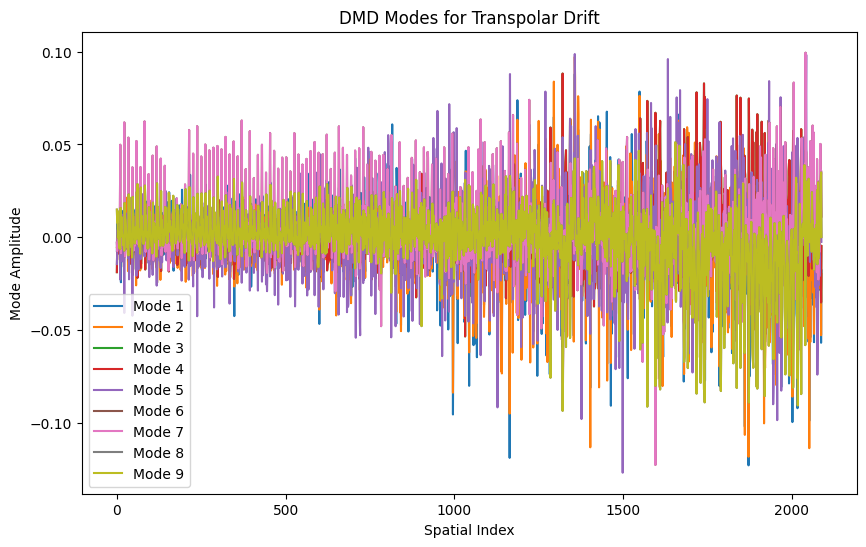

C:\Users\danie\AppData\Local\Temp\ipykernel_21628\3278184399.py:46: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frequencies, use_line_collection=True)


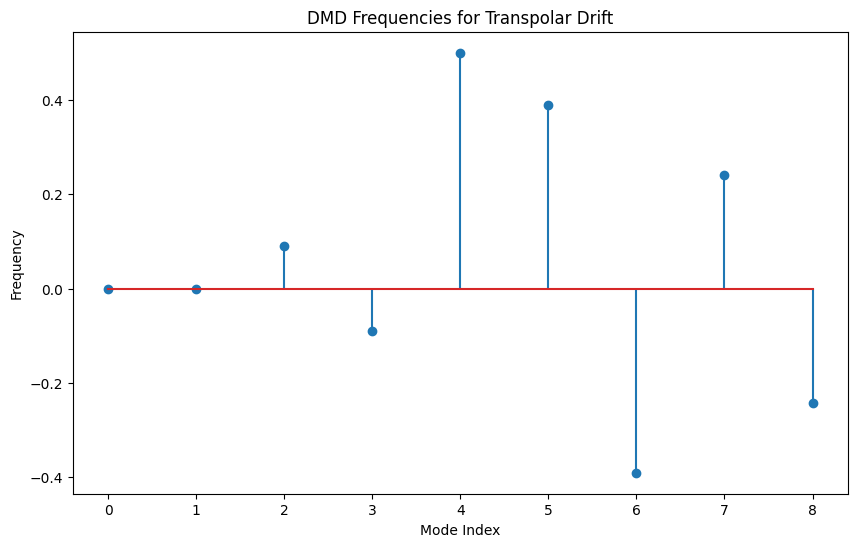

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = fd[fd['NAME'] ==  'Transpolar Drift']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Obtener los modos DMD y las frecuencias
modes = dmd.modes
frequencies = dmd.frequency

# Graficar los modos DMD
plt.figure(figsize=(10, 6))
for i, mode in enumerate(modes.T):
    plt.plot(mode.real, label=f'Mode {i+1}')

plt.title('DMD Modes for Transpolar Drift')
plt.xlabel('Spatial Index')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.show()

# Graficar las frecuencias DMD
plt.figure(figsize=(10, 6))
plt.stem(frequencies, use_line_collection=True)
plt.title('DMD Frequencies for Transpolar Drift')
plt.xlabel('Mode Index')
plt.ylabel('Frequency')
plt.show()


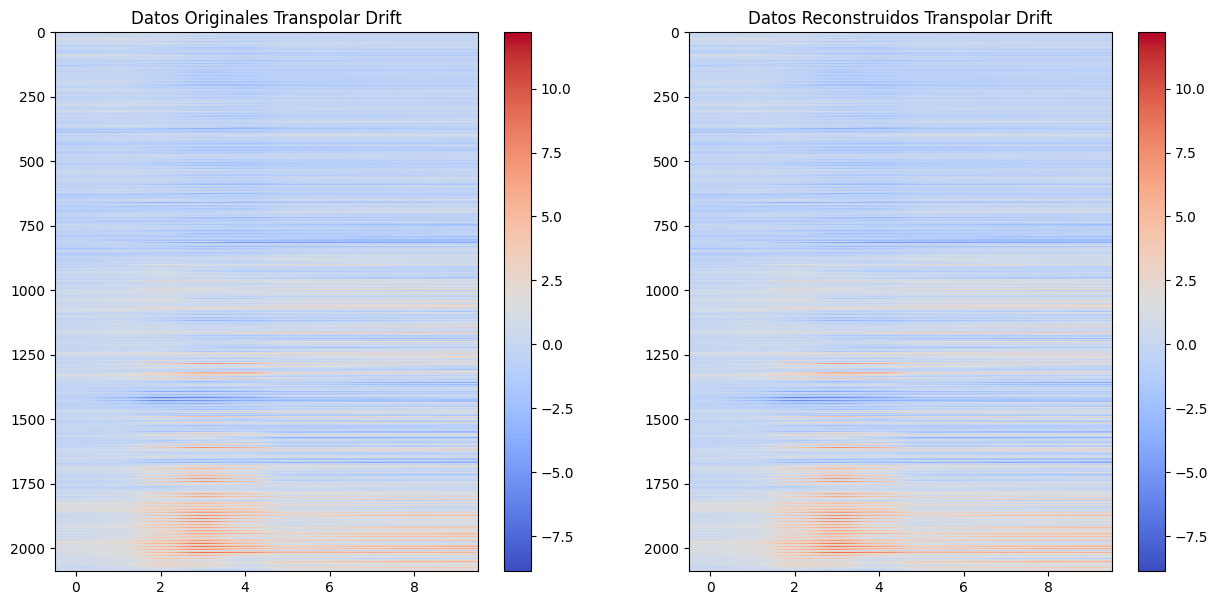

latitude     68.311745  69.920820  71.528090  73.134490  74.741230  79.583650  \
longitude   -8.674699  -9.350649  -10.140845 -11.076923 -12.203390 -8.780488    
time                                                                            
1850.041667  -0.348688  -0.092932  -1.359574  -1.871440  -0.702121   0.551171   
1850.125000  -0.262663   0.160381  -0.843231  -2.304280  -2.077843  -1.722133   
1850.208333  -0.064513   0.126161  -0.781308  -2.368322  -1.965179  -1.125168   
1850.291667   0.087574   0.199578   0.773263   0.536992   0.390642   0.509673   
1850.375000   0.493439   0.403118  -0.054807  -0.465899  -0.587925  -0.595644   

latitude     81.192550  82.788070  84.395035             
longitude   -5.294117   6.428571   8.181818   24.545454  
time                                                     
1850.041667   0.770786   1.005651   0.898119   0.983622  
1850.125000  -1.591085  -1.231815  -1.102578  -0.832592  
1850.208333  -0.965069  -0.806568  -0.632485  -0.554250  
185

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = fd[fd['NAME'] == 'Transpolar Drift'] #'Transpolar Drift'

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Mostrar los datos originales y reconstruidos para comparar
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Originales Transpolar Drift')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Reconstruidos Transpolar Drift')

plt.show()


# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


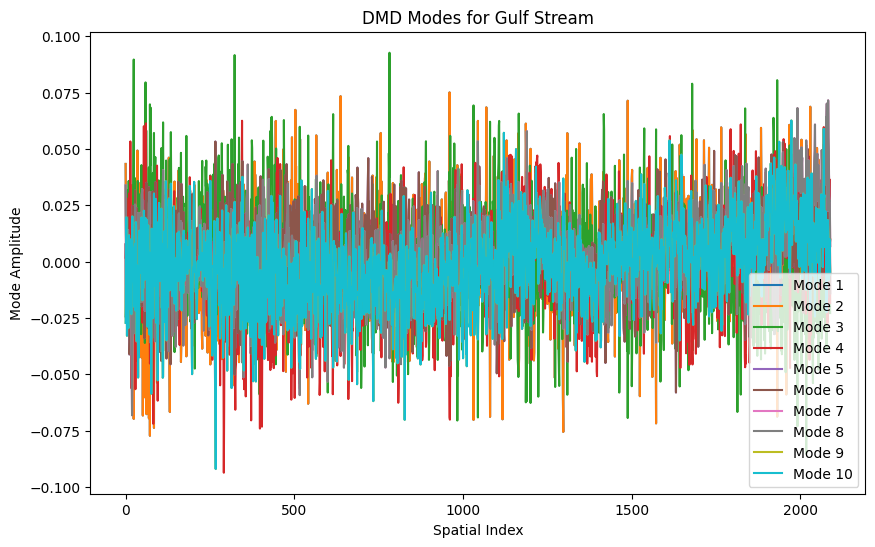

C:\Users\danie\AppData\Local\Temp\ipykernel_21628\4084629939.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frequencies, use_line_collection=True)


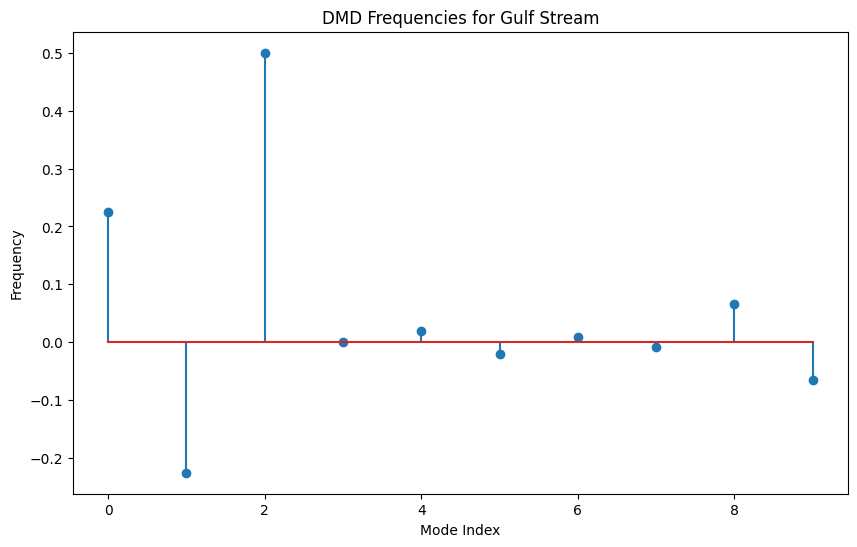

In [72]:
# Filtrar los datos para la Corriente Transpolar
transpolar_data = fd[fd['NAME'] ==  'Gulf Stream']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Obtener los modos DMD y las frecuencias
modes = dmd.modes
frequencies = dmd.frequency

# Graficar los modos DMD
plt.figure(figsize=(10, 6))
for i, mode in enumerate(modes.T):
    plt.plot(mode.real, label=f'Mode {i+1}')

plt.title('DMD Modes for Gulf Stream')
plt.xlabel('Spatial Index')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.show()

# Graficar las frecuencias DMD
plt.figure(figsize=(10, 6))
plt.stem(frequencies, use_line_collection=True)
plt.title('DMD Frequencies for Gulf Stream')
plt.xlabel('Mode Index')
plt.ylabel('Frequency')
plt.show()

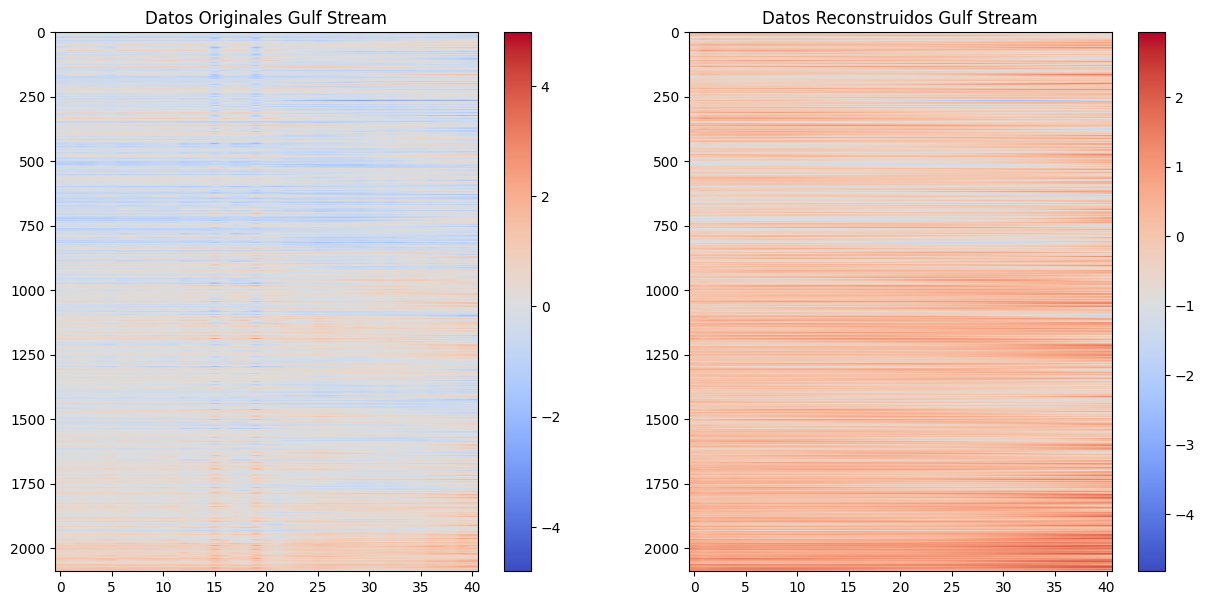

latitude     21.702112             23.308678                                   \
longitude   -87.403850 -85.673080 -88.252426 -86.504850 -83.009710 -81.262140   
time                                                                            
1850.041667   1.018474   0.609433   0.796435   1.075845   1.200231   1.210797   
1850.125000   0.401037   0.337730   0.318144   0.395738   0.454296   0.467978   
1850.208333   0.109354   0.008486   0.259430   0.353918   0.349700   0.352200   
1850.291667  -0.110625  -0.110539  -0.175766  -0.138688  -0.092226  -0.080696   
1850.375000   0.882618   1.193243   1.063424   0.972324   0.952477   0.968198   

latitude     24.915112                                   ...  36.171963  \
longitude   -88.669950 -86.896550 -85.123150 -83.349754  ... -63.646408   
time                                                     ...              
1850.041667   1.259517   1.346483   1.386916   1.362930  ...   0.586124   
1850.125000   0.475426   0.494503   0.506565   0.49

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = fd[fd['NAME'] == 'Gulf Stream'] #'Transpolar Drift'

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Mostrar los datos originales y reconstruidos para comparar
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Originales Gulf Stream')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Reconstruidos Gulf Stream')

plt.show()


# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


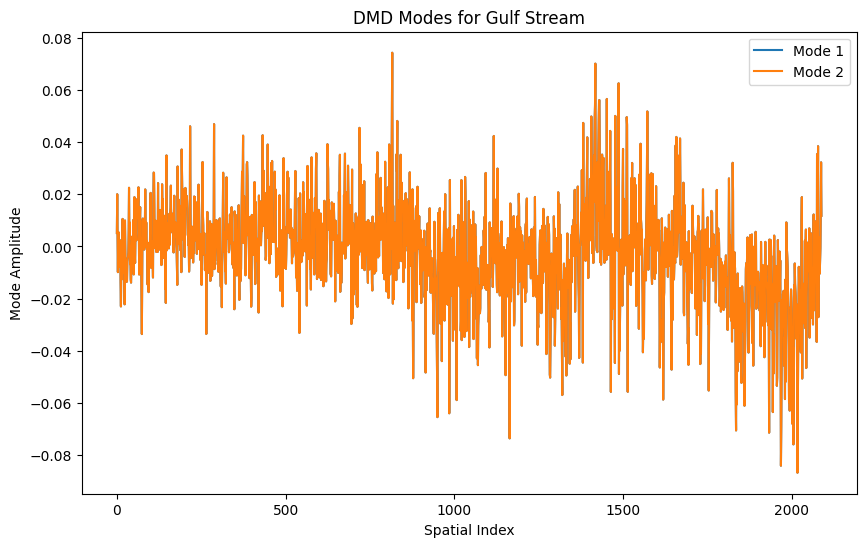

C:\Users\danie\AppData\Local\Temp\ipykernel_21628\1326890023.py:41: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frequencies, use_line_collection=True)


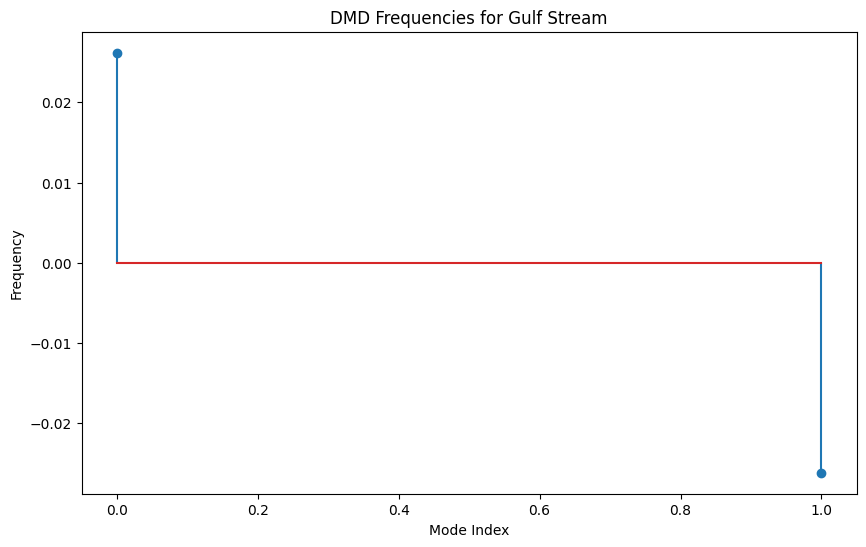

In [76]:
# Filtrar los datos para la Corriente Transpolar
transpolar_data = fd[fd['NAME'] ==  'East Greenland']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Obtener los modos DMD y las frecuencias
modes = dmd.modes
frequencies = dmd.frequency

# Graficar los modos DMD
plt.figure(figsize=(10, 6))
for i, mode in enumerate(modes.T):
    plt.plot(mode.real, label=f'Mode {i+1}')

plt.title('DMD Modes for East Greenland')
plt.xlabel('Spatial Index')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.show()

# Graficar las frecuencias DMD
plt.figure(figsize=(10, 6))
plt.stem(frequencies, use_line_collection=True)
plt.title('DMD Frequencies for East Greenland')
plt.xlabel('Mode Index')
plt.ylabel('Frequency')
plt.show()

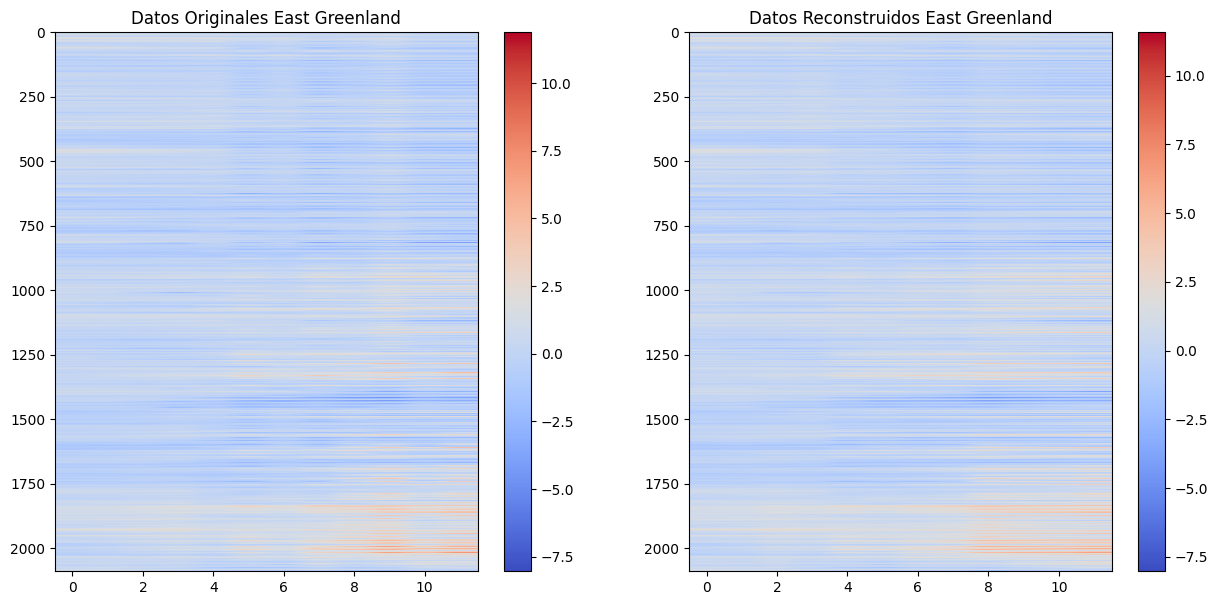

latitude     58.663330  60.272194  61.880825  63.490154  65.093376  66.700066  \
longitude   -40.000000 -38.918920 -39.056602 -37.800000 -32.553192 -28.314608   
time                                                                            
1850.041667   0.682418   0.622538   0.289374   1.011677   0.303549   0.121378   
1850.125000   0.571929   0.401055  -0.084907   0.565367  -0.268829  -0.044238   
1850.208333   0.632100   0.510509   0.581936   1.201578   0.199925   0.666284   
1850.291667   0.739256   0.589679   0.633611   0.829539   0.669277   0.627164   
1850.375000   0.614538   0.515322   0.552822   0.534652   0.140437  -0.106346   

latitude                68.311745             69.920820  71.528090  73.134490  
longitude   -24.269663 -26.024096 -21.686747 -18.701298 -20.281690 -16.615385  
time                                                                           
1850.041667  -0.145822  -0.503942  -0.224263  -0.148241  -0.425970  -0.476819  
1850.125000  -1.277801  -1.9722

In [77]:
# Filtrar los datos para la Corriente Transpolar
transpolar_data = fd[fd['NAME'] == 'East Greenland'] #'Transpolar Drift'

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Mostrar los datos originales y reconstruidos para comparar
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Originales East Greenland')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Reconstruidos East Greenland')

plt.show()


# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


In [54]:
filtered_data

longitude   latitude  temperature  climatology         time  \
0        8.181818  84.395035     0.898119   -27.573929  1850.041667   
1       24.545454  84.395035     0.953854   -27.100426  1850.041667   
2        6.428571  82.788071     1.005651   -23.097878  1850.041667   
3       32.142857  82.788071     0.967621   -22.109631  1850.041667   
4       33.962265  76.349915     1.502895    -9.693192  1850.041667   
...           ...        ...          ...          ...          ...   
20350 -127.800003 -63.490154    -0.919924    -0.318187  1850.958333   
20351 -124.199997 -63.490154    -0.858255    -0.007475  1850.958333   
20352 -104.096382 -68.311745    -0.238826    -2.620099  1850.958333   
20353  -99.759033 -68.311745    -0.309772    -2.405196  1850.958333   
20354  -95.421684 -68.311745    -0.257640    -2.333611  1850.958333   

                           geometry  index_right  OBJECTID Layer  OBJECTID_1  \
0          POINT (8.18182 84.39503)           46       120   1pt           8   
1         POINT (24.54545 84.39503)           46       120   1pt           8   
2          POINT (6.42857 82.78807)           46       120   1pt           8   
3         POINT (32.14286 82.78807)           47       121   1pt          65   
4         POINT (33.96227 76.34991)           47       121   1pt          65   
...                             ...          ...       ...   ...         ...   
20350  POINT (-127.80000 -63.49015)            3        77   1pt          96   
20351  POINT (-124.20000 -63.49015)            3        77   1pt          96   
20352  POINT (-104.09638 -68.31174)           49       123   1pt          29   
20353   POINT (-99.75903 -68.31174)           49       123   1pt          29   
20354   POINT (-95.42168 -68.31174)           49       123   1pt          29   

       TEMP    SCALE                                     NAME  
0      cold  5000000                         Transpolar Drift  
1      cold  5000000                         Transpolar Drift  
2      cold  5000000                         Transpolar Drift  
3      warm  5000000                                Norwegian  
4      warm  5000000                                Norwegian  
...     ...      ...                                      ...  
20350  cold  5000000  West Wind Drift / Antarctic Circumpolar  
20351  cold  5000000  West Wind Drift / Antarctic Circumpolar  
20352  cold  5000000     East Wind Drift / Antarctic Subpolar  
20353  cold  5000000     East Wind Drift / Antarctic Subpolar  
20354  cold  5000000     East Wind Drift / Antarctic Subpolar  

[20355 rows x 13 columns]

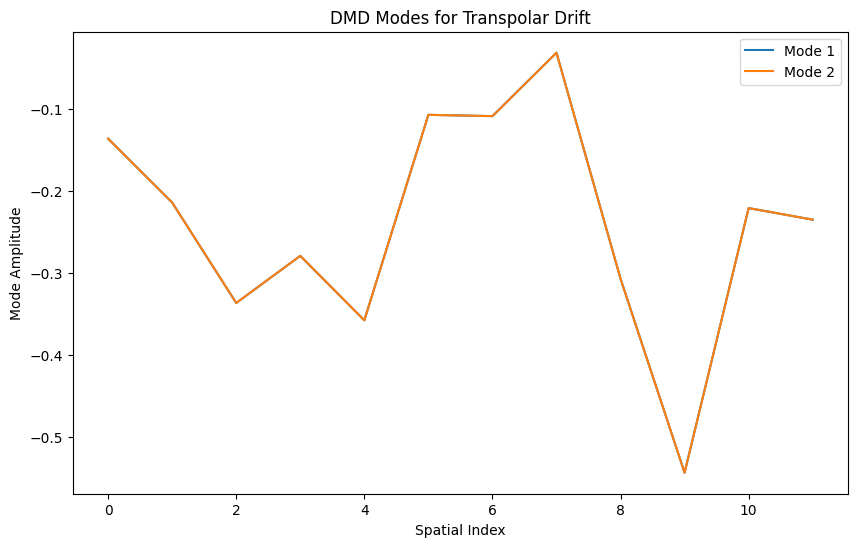

C:\Users\danie\AppData\Local\Temp\ipykernel_21628\3122659357.py:46: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frequencies, use_line_collection=True)


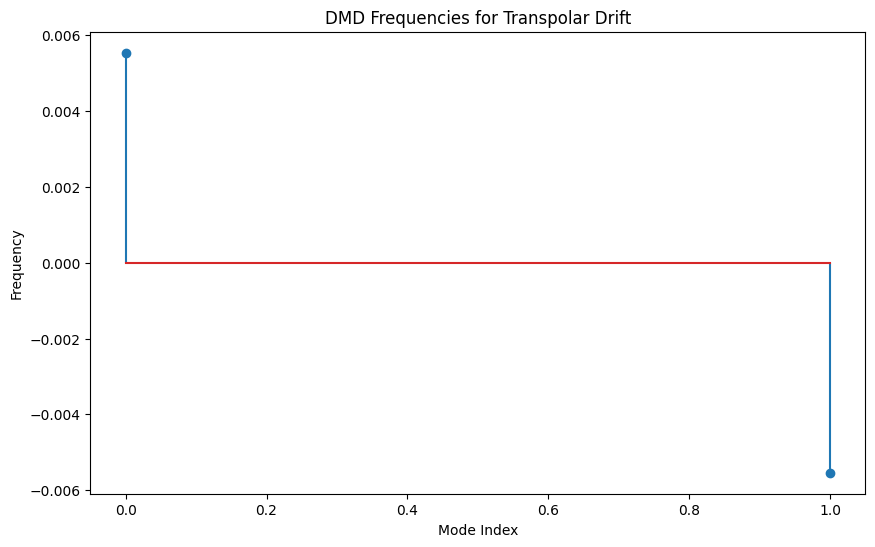

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = filtered_data[filtered_data['NAME'] == 'North Equatorial']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=2)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Obtener los modos DMD y las frecuencias
modes = dmd.modes
frequencies = dmd.frequency

# Graficar los modos DMD
plt.figure(figsize=(10, 6))
for i, mode in enumerate(modes.T):
    plt.plot(mode.real, label=f'Mode {i+1}')

plt.title('DMD Modes for Transpolar Drift')
plt.xlabel('Spatial Index')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.show()

# Graficar las frecuencias DMD
plt.figure(figsize=(10, 6))
plt.stem(frequencies, use_line_collection=True)
plt.title('DMD Frequencies for Transpolar Drift')
plt.xlabel('Mode Index')
plt.ylabel('Frequency')
plt.show()


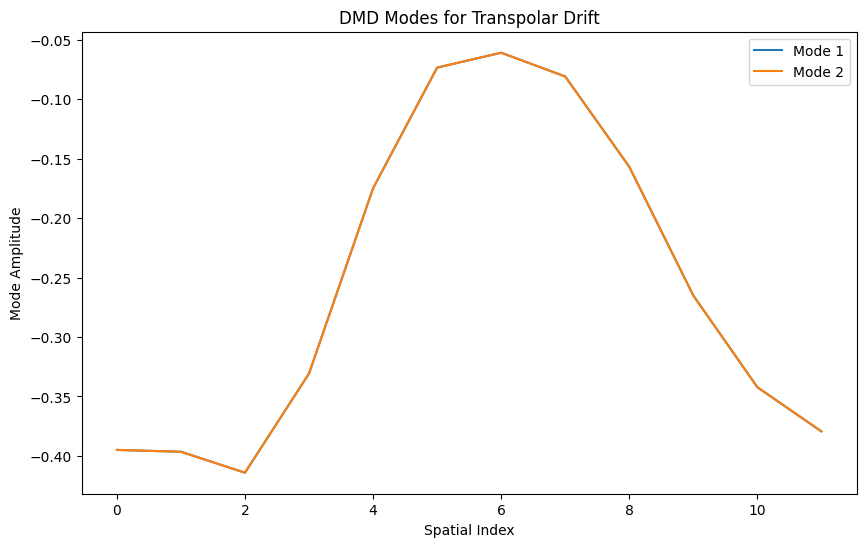

C:\Users\danie\AppData\Local\Temp\ipykernel_21628\1306720271.py:46: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(frequencies, use_line_collection=True)


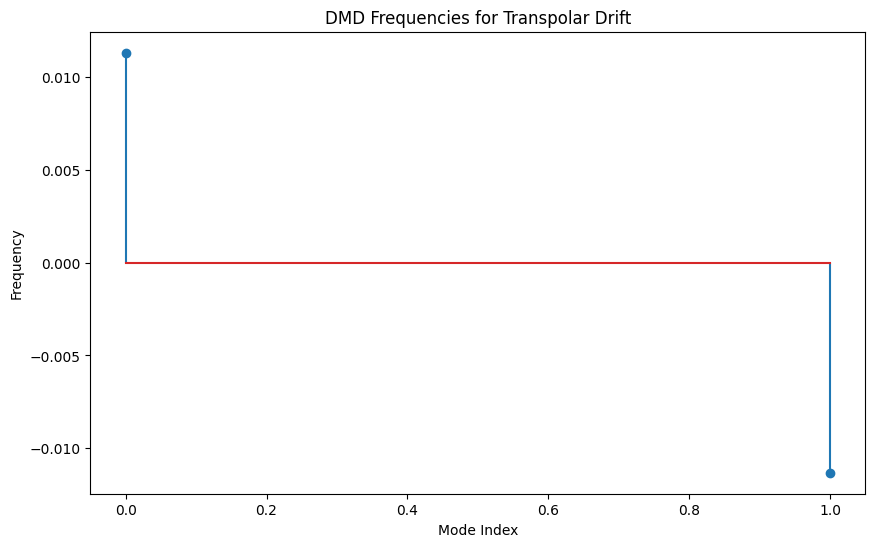

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = filtered_data[filtered_data['NAME'] == 'Transpolar Drift']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'climatology']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='climatology')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=2)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Obtener los modos DMD y las frecuencias
modes = dmd.modes
frequencies = dmd.frequency

# Graficar los modos DMD
plt.figure(figsize=(10, 6))
for i, mode in enumerate(modes.T):
    plt.plot(mode.real, label=f'Mode {i+1}')

plt.title('DMD Modes for Transpolar Drift')
plt.xlabel('Spatial Index')
plt.ylabel('Mode Amplitude')
plt.legend()
plt.show()

# Graficar las frecuencias DMD
plt.figure(figsize=(10, 6))
plt.stem(frequencies, use_line_collection=True)
plt.title('DMD Frequencies for Transpolar Drift')
plt.xlabel('Mode Index')
plt.ylabel('Frequency')
plt.show()


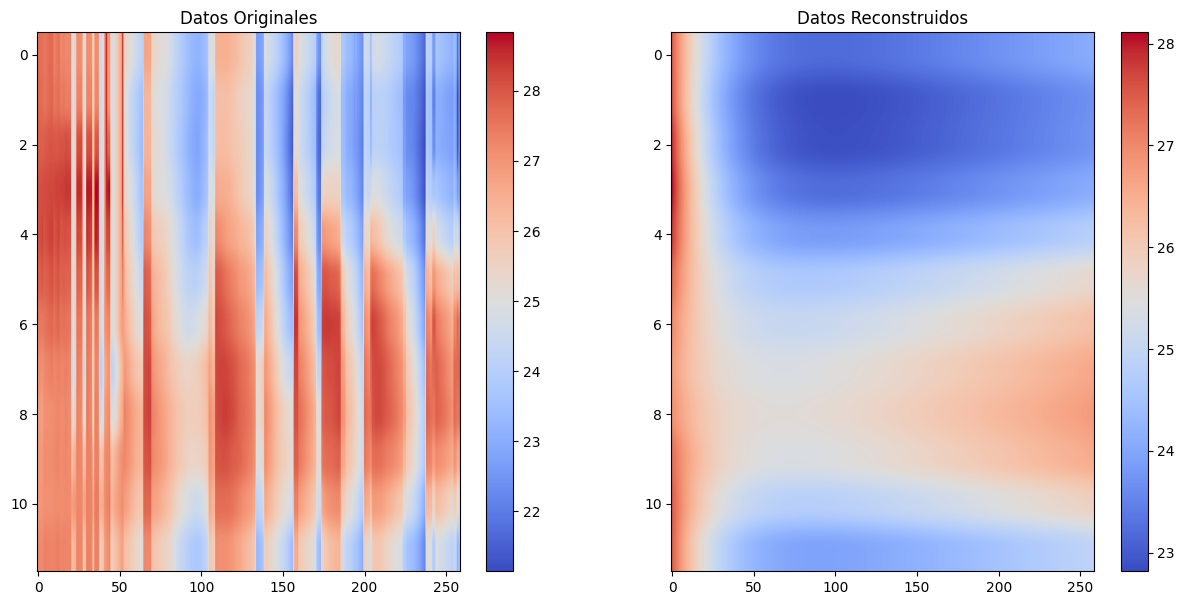

latitude     -5.626614                                       -4.018409   \
longitude    93.632286   95.246635   96.860985   98.475334   87.589287    
time                                                                      
1850.041667   27.517053   27.351285   27.191276   27.036832   26.887770   
1850.125000   27.592143   27.411069   27.236263   27.067514   26.904619   
1850.208333   27.937500   27.746002   27.561120   27.382632   27.210324   
1850.291667   28.111761   27.926306   27.747267   27.574431   27.407590   
1850.375000   27.847617   27.692530   27.542851   27.398399   27.259000   

latitude                                                                 ...  \
longitude    89.196426   90.803574   92.410713   94.017860   95.625000   ...   
time                                                                     ...   
1850.041667   26.743908   26.605072   26.471096   26.341816   26.217076  ...   
1850.125000   26.747384   26.595618   26.449141   26.307773   26.171346  ...   

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = filtered_data[filtered_data['NAME'] ==  'North Equatorial']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'climatology']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='climatology')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=2)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Mostrar los datos originales y reconstruidos para comparar
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Originales')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Reconstruidos')

plt.show()

# Guardar los datos reconstruidos en un archivo CSV
reconstructed_df.to_csv('datos/Reconstructed_Transpolar_Drift.csv', index=True)

# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


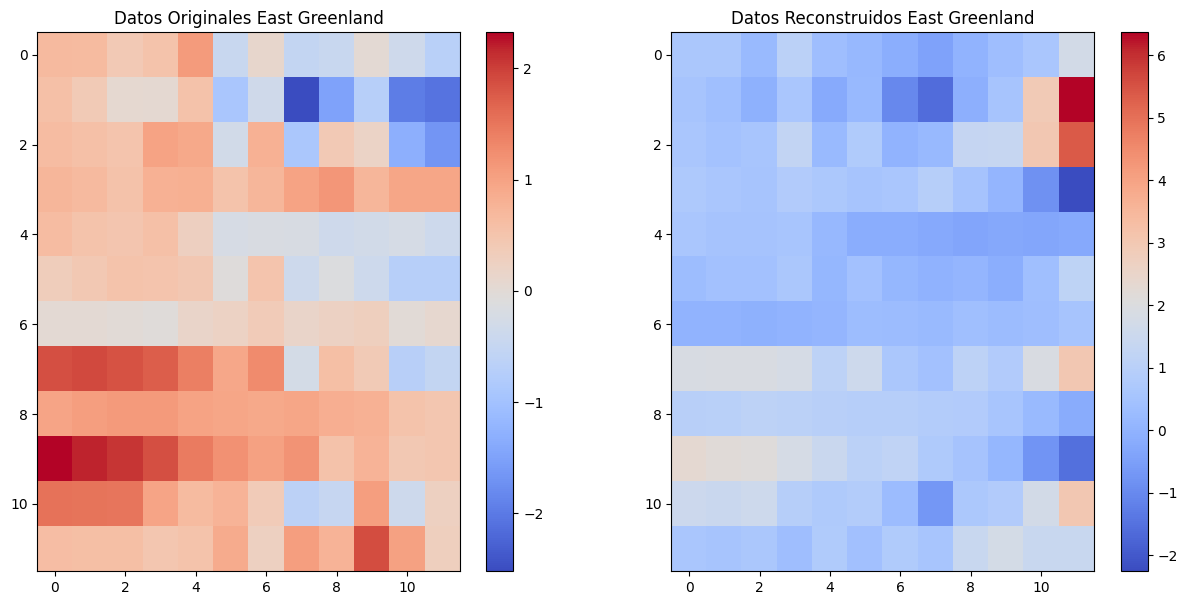

latitude     58.663330  60.272194  61.880825  63.490154  65.093376  66.700066  \
longitude   -40.000000 -38.918919 -39.056602 -37.799999 -32.553192 -28.314608   
time                                                                            
1850.041667   0.671329   0.661304   0.216682   1.070122   0.357580   0.148077   
1850.125000   0.568776   0.374226  -0.036651   0.608171  -0.231245   0.176777   
1850.208333   0.629151   0.500505   0.589414   1.275268   0.227648   0.805820   
1850.291667   0.730498   0.638546   0.565587   0.827658   0.675767   0.545845   
1850.375000   0.623813   0.510232   0.518417   0.581786   0.159591  -0.135373   

latitude                68.311745             69.920822  71.528091  73.134491  
longitude   -24.269663 -26.024096 -21.686747 -18.701298 -20.281691 -16.615385  
time                                                                           
1850.041667  -0.100827  -0.407986   0.033473   0.343820   0.623318   1.725214  
1850.125000  -1.026238  -1.6099

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = filtered_data[filtered_data['NAME'] == 'East Greenland']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Mostrar los datos originales y reconstruidos para comparar
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Originales East Greenland')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Reconstruidos East Greenland')

plt.show()

# Guardar los datos reconstruidos en un archivo CSV
reconstructed_df.to_csv('datos/Reconstructed_Transpolar_Drift.csv', index=True)

# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


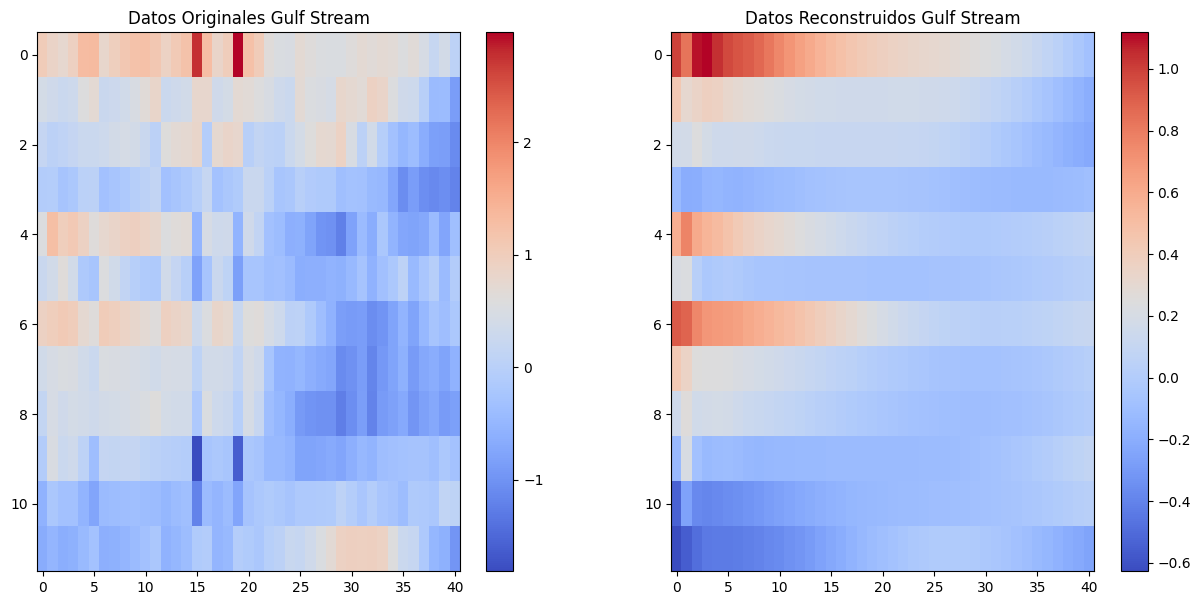

latitude     21.702112             23.308678                                   \
longitude   -87.403847 -85.673080 -88.252426 -86.504852 -83.009712 -81.262138   
time                                                                            
1850.041667   0.994375   0.829506   1.092620   1.118098   1.039218   0.970846   
1850.125000   0.429643   0.308666   0.341918   0.378779   0.362200   0.326574   
1850.208333   0.176679   0.178754   0.242285   0.189530   0.150772   0.150270   
1850.291667  -0.127133  -0.203499  -0.193053  -0.152864  -0.149893  -0.161721   
1850.375000   0.581589   0.768117   0.604269   0.551783   0.515429   0.469559   

latitude     24.915112                                   ...  36.171963  \
longitude   -88.669952 -86.896553 -85.123154 -83.349754  ... -63.646408   
time                                                     ...              
1850.041667   0.938866   0.912365   0.868982   0.811495  ...   0.219685   
1850.125000   0.297426   0.277364   0.259099   0.23

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = filtered_data[filtered_data['NAME'] == 'Gulf Stream']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=10)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Mostrar los datos originales y reconstruidos para comparar
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Originales Gulf Stream')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Reconstruidos Gulf Stream')

plt.show()

# Guardar los datos reconstruidos en un archivo CSV
reconstructed_df.to_csv('datos/Reconstructed_Transpolar_Drift.csv', index=True)

# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


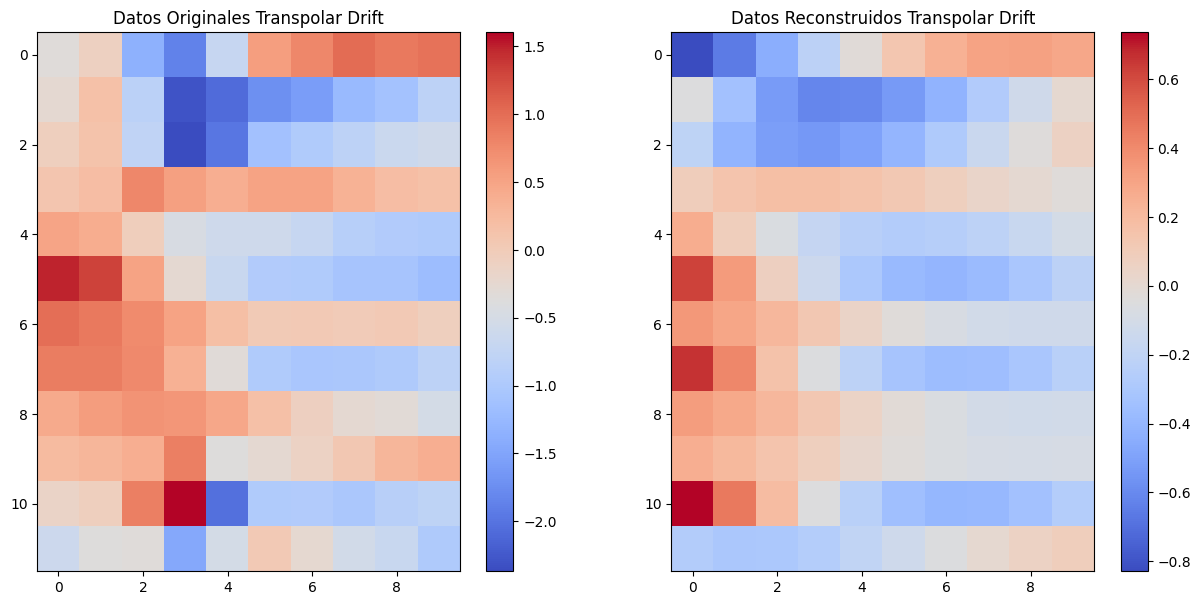

latitude     68.311745  69.920822  71.528091  73.134491  74.741226  79.583649  \
longitude   -8.674699  -9.350649  -10.140845 -11.076923 -12.203390 -8.780488    
time                                                                            
1850.041667  -0.829211  -0.656168  -0.442880  -0.222882  -0.023388   0.136562   
1850.125000  -0.048372  -0.337360  -0.525543  -0.612226  -0.608763  -0.534667   
1850.208333  -0.210868  -0.407063  -0.513949  -0.537928  -0.493762  -0.401073   
1850.291667   0.094614   0.149517   0.175255   0.174991   0.154269   0.119854   
1850.375000   0.261772   0.084420  -0.065236  -0.175523  -0.241855  -0.265774   

latitude     81.192551  82.788071  84.395035             
longitude   -5.294117   6.428571   8.181818   24.545454  
time                                                     
1850.041667   0.246598   0.304401   0.314266   0.285198  
1850.125000  -0.413597  -0.269703  -0.124692   0.004200  
1850.208333  -0.281012  -0.153456  -0.034948   0.062537  
185

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = filtered_data[filtered_data['NAME'] == 'Transpolar Drift']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=2)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Mostrar los datos originales y reconstruidos para comparar
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Originales Transpolar Drift')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title('Datos Reconstruidos Transpolar Drift')

plt.show()

# Guardar los datos reconstruidos en un archivo CSV
reconstructed_df.to_csv('datos/Reconstructed_Transpolar_Drift.csv', index=True)

# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


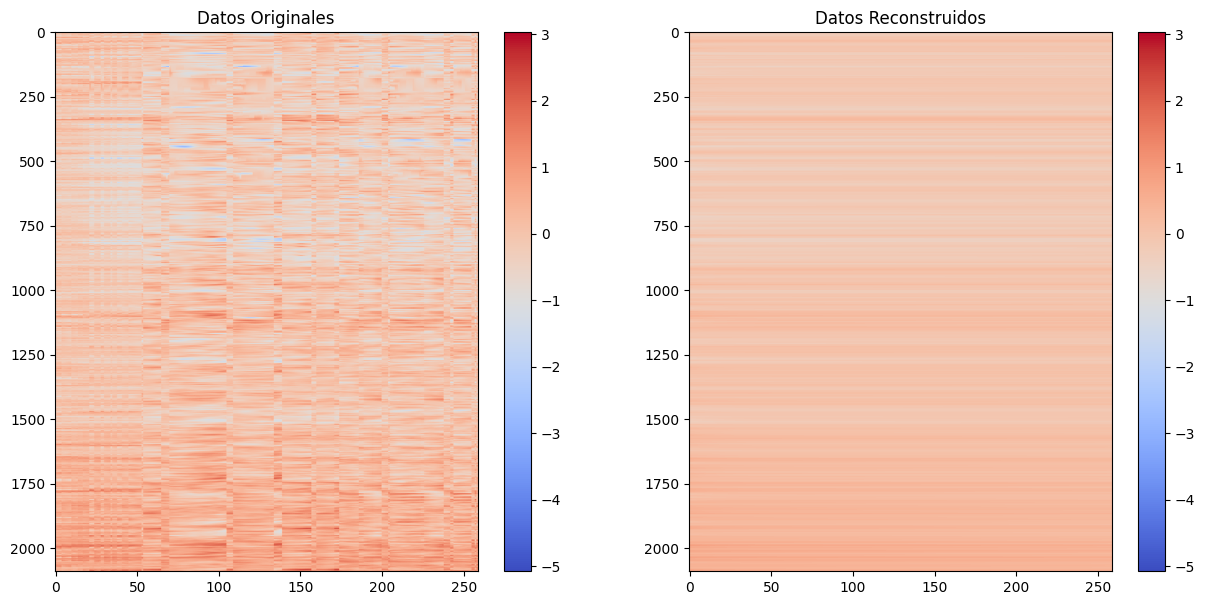

latitude     -5.626614                                       -4.018409   \
longitude    93.632286   95.246635   96.860985   98.475334   87.589287    
time                                                                      
1850.041667   -0.124807   -0.119139   -0.113796   -0.108760   -0.104012   
1850.125000   -0.200317   -0.194428   -0.188872   -0.183632   -0.178689   
1850.208333   -0.327909   -0.329591   -0.331159   -0.332620   -0.333981   
1850.291667   -0.231675   -0.236444   -0.240923   -0.245131   -0.249081   
1850.375000   -0.191439   -0.200896   -0.209792   -0.218160   -0.226030   

latitude                                                                 ...  \
longitude    89.196426   90.803574   92.410713   94.017860   95.625000   ...   
time                                                                     ...   
1850.041667   -0.099537   -0.095317   -0.091339   -0.087589   -0.084054  ...   
1850.125000   -0.174026   -0.169627   -0.165476   -0.161560   -0.157864  ...   

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydmd import DMD  # Asegúrate de tener la biblioteca PyDMD instalada

# Filtrar los datos para la Corriente Transpolar
transpolar_data = filtered_data[filtered_data['NAME'] == 'North Equatorial']

# Asegurarnos de que los datos estén ordenados por tiempo
transpolar_data = transpolar_data.sort_values(by='time')

# Seleccionar las variables de interés para DMD (lat, lon, climatology)
transpolar_data = transpolar_data[['time', 'latitude', 'longitude', 'temperature']]

# Crear una matriz con las variables de interés
# Pivotear los datos para obtener una matriz donde las filas son los tiempos y las columnas son combinaciones de lat y lon
transpolar_pivot = transpolar_data.pivot_table(index='time', columns=['latitude', 'longitude'], values='temperature')

# Imputar datos faltantes (por ejemplo, usando interpolación)
transpolar_pivot = transpolar_pivot.interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

# Convertir los datos a una matriz numpy
X = transpolar_pivot.values

# Aplicar la Descomposición Dinámica de Modos (DMD)
dmd = DMD(svd_rank=2)  # Ajusta el rango de SVD según sea necesario
dmd.fit(X)

# Reconstruir los datos usando DMD
X_reconstructed = dmd.reconstructed_data.real

# Convertir los datos reconstruidos de vuelta a un DataFrame
reconstructed_df = pd.DataFrame(X_reconstructed, index=transpolar_pivot.index, columns=transpolar_pivot.columns)

# Obtener los límites de la escala de color
vmin = min(X.min(), X_reconstructed.min())
vmax = max(X.max(), X_reconstructed.max())

# Mostrar los datos originales y reconstruidos para comparar con la misma escala de color
plt.figure(figsize=(15, 7))

# Datos originales
plt.subplot(1, 2, 1)
plt.imshow(X, aspect='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Datos Originales')

# Datos reconstruidos
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, aspect='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Datos Reconstruidos')

plt.show()

# Guardar los datos reconstruidos en un archivo CSV
reconstructed_df.to_csv('datos/Reconstructed_Transpolar_Drift.csv', index=True)

# Mostrar los primeros datos reconstruidos
print(reconstructed_df.head())


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\danie\AppData\Local\Temp\ipykernel_21628\2478041408.py:73: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  filtered_gdf = gpd.sjoin(gdf, buffered_gdf, how='inner', op='within')
C:\Users\danie\AppData\Local\Temp\ipykernel_21628\2478041408.py:88: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  temperature = nc_data.variables['temperature'][-2
C:\Users\danie\AppData\Local\Temp\ipykernel_21628\2478041408.p

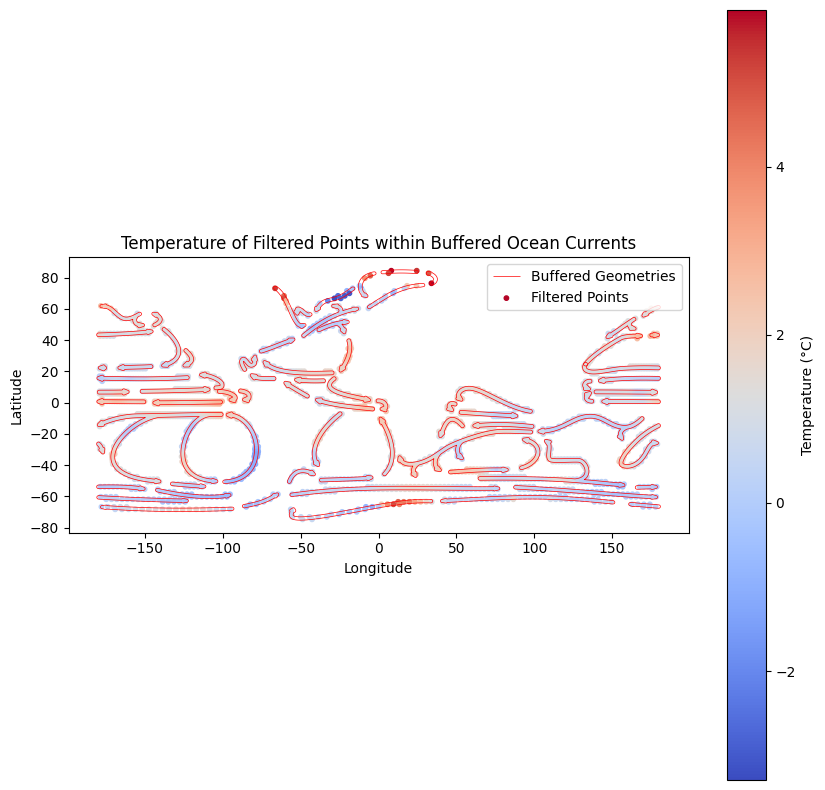

In [28]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import shape, mapping
import json
import netCDF4 as nc
import matplotlib.colors as mcolors

# Define the buffer distance (e.g., 0.1 degrees which is approximately 10km near the equator)
buffer_distance = 1  # in degrees

# Load the GeoJSON file content to inspect it directly
file_path = 'datos/Major_Ocean_Currents.geojson'
with open(file_path, 'r') as file:
    geojson_data = json.load(file)

# Buffer each feature in the GeoJSON data
buffered_features = []
for feature in geojson_data['features']:
    geom = shape(feature['geometry'])
    buffered_geom = geom.buffer(buffer_distance)
    buffered_feature = {
        'type': 'Feature',
        'properties': feature['properties'],
        'geometry': mapping(buffered_geom)
    }
    buffered_features.append(buffered_feature)

# Create a new GeoJSON structure for buffered geometries
buffered_geojson_data = {
    'type': 'FeatureCollection',
    'features': buffered_features
}

# Save the new buffered GeoJSON to a file
buffered_file_path_corrected = 'datos/Buffered_Major_Ocean_Currents.geojson'
with open(buffered_file_path_corrected, 'w') as file:
    json.dump(buffered_geojson_data, file)

# Function to plot geometries using matplotlib
def plot_geometries(original_geojson, buffered_geojson, ax):
    for feature in original_geojson['features']:
        geom = shape(feature['geometry'])
        xs, ys = geom.exterior.xy
        ax.plot(xs, ys, color='blue', linewidth=0.5, label='Original' if feature == original_geojson['features'][0] else "")
    
    for feature in buffered_geojson['features']:
        geom = shape(feature['geometry'])
        xs, ys = geom.exterior.xy
        ax.plot(xs, ys, color='red', linewidth=0.5, label='Buffered' if feature == buffered_geojson['features'][0] else "")



# Load the NetCDF file
nc_file_path = 'datos/Land_and_Ocean_EqualArea.nc'
nc_data = nc.Dataset(nc_file_path)

# Extract the relevant variables (assuming variables named 'longitude', 'latitude')
lon = nc_data.variables['longitude'][:]
lat = nc_data.variables['latitude'][:]
time = nc_data.variables['time'][:]

# Create a GeoDataFrame from the NetCDF data
data = {'longitude': lon, 'latitude': lat}
df = pd.DataFrame(data)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Load the buffered GeoJSON data
buffered_gdf = gpd.read_file(buffered_file_path_corrected)

# Perform a spatial join to filter points within the buffered geometries
filtered_gdf = gpd.sjoin(gdf, buffered_gdf, how='inner', op='within')

# Save the filtered data to a new file
filtered_file_path = 'datos/Filtered_Land_and_Ocean_EqualArea.geojson'
filtered_gdf.to_file(filtered_file_path, driver='GeoJSON')

# Function to plot the filtered points
def plot_filtered_points(filtered_gdf, buffered_gdf, ax):
    buffered_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5, label='Buffered Geometries')
    filtered_gdf.plot(ax=ax, color='blue', markersize=1, label='Filtered Points')




# Extract the temperature data (assuming variable named 'temperature')
temperature = nc_data.variables['temperature'][-2
, :]  # Get the last measurement

# Add the temperature to the GeoDataFrame
gdf['temperature'] = temperature

# Filter the GeoDataFrame again to include the temperature
filtered_gdf_with_temp = gpd.sjoin(gdf, buffered_gdf, how='inner', op='within')

# Ensure the filtered GeoDataFrame includes the temperature
filtered_gdf_with_temp = filtered_gdf_with_temp.dropna(subset=['temperature'])

# Function to plot the filtered points with temperature
def plot_temperature(filtered_gdf_with_temp, buffered_gdf, ax):
    buffered_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5, label='Buffered Geometries')
    
    # Plot the points with temperature data
    scatter = ax.scatter(
        filtered_gdf_with_temp.geometry.x, 
        filtered_gdf_with_temp.geometry.y, 
        c=filtered_gdf_with_temp['temperature'], 
        cmap='coolwarm', 
        s=10, 
        label='Filtered Points'
    )
    plt.colorbar(scatter, ax=ax, label='Temperature (°C)')

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the filtered points with temperature
plot_temperature(filtered_gdf_with_temp, buffered_gdf, ax)

# Add legend and titles
plt.legend()
plt.title('Temperature of Filtered Points within Buffered Ocean Currents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show plot
plt.show()


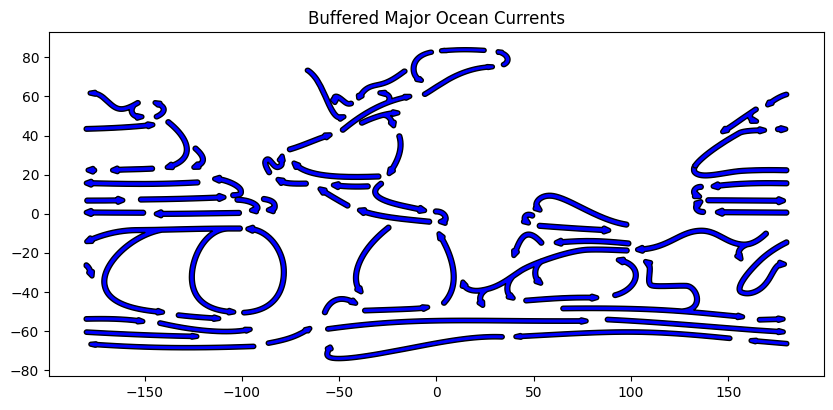

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Cargar el archivo GeoJSON con los polígonos buffer
buffered_file_path = 'datos/Buffered_Major_Ocean_Currents.geojson'
buffered_currents = gpd.read_file(buffered_file_path)

# Visualizar los polígonos buffer
fig, ax = plt.subplots(figsize=(10, 10))
buffered_currents.plot(ax=ax, color='blue', edgecolor='k')
ax.set_title('Buffered Major Ocean Currents')
plt.show()


In [32]:
filtered_gdf

longitude   latitude                      geometry  index_right  \
39       8.181818  84.395035      POINT (8.18182 84.39503)           46   
40      24.545454  84.395035     POINT (24.54545 84.39503)           46   
64       6.428571  82.788071      POINT (6.42857 82.78807)           46   
66      32.142857  82.788071     POINT (32.14286 82.78807)           47   
231     33.962265  76.349915     POINT (33.96227 76.34991)           47   
...           ...        ...                           ...          ...   
15391 -112.771088 -68.311745  POINT (-112.77109 -68.31174)           49   
15392 -108.433739 -68.311745  POINT (-108.43374 -68.31174)           49   
15393 -104.096382 -68.311745  POINT (-104.09638 -68.31174)           49   
15394  -99.759033 -68.311745   POINT (-99.75903 -68.31174)           49   
15395  -95.421684 -68.311745   POINT (-95.42168 -68.31174)           49   

       OBJECTID Layer  OBJECTID_1  TEMP    SCALE  \
39          120   1pt           8  cold  5000000   
40          120   1pt           8  cold  5000000   
64          120   1pt           8  cold  5000000   
66          121   1pt          65  warm  5000000   
231         121   1pt          65  warm  5000000   
...         ...   ...         ...   ...      ...   
15391       123   1pt          29  cold  5000000   
15392       123   1pt          29  cold  5000000   
15393       123   1pt          29  cold  5000000   
15394       123   1pt          29  cold  5000000   
15395       123   1pt          29  cold  5000000   

                                       NAME  
39                         Transpolar Drift  
40                         Transpolar Drift  
64                         Transpolar Drift  
66                                Norwegian  
231                               Norwegian  
...                                     ...  
15391  East Wind Drift / Antarctic Subpolar  
15392  East Wind Drift / Antarctic Subpolar  
15393  East Wind Drift / Antarctic Subpolar  
15394  East Wind Drift / Antarctic Subpolar  
15395  East Wind Drift / Antarctic Subpolar  

[2133 rows x 10 columns]

In [17]:
filtered_gdf_with_temp

longitude   latitude                      geometry  index_right  \
39       8.181818  84.395035      POINT (8.18182 84.39503)           46   
40      24.545454  84.395035     POINT (24.54545 84.39503)           46   
64       6.428571  82.788071      POINT (6.42857 82.78807)           46   
66      32.142857  82.788071     POINT (32.14286 82.78807)           47   
231     33.962265  76.349915     POINT (33.96227 76.34991)           47   
...           ...        ...                           ...          ...   
15391 -112.771088 -68.311745  POINT (-112.77109 -68.31174)           49   
15392 -108.433739 -68.311745  POINT (-108.43374 -68.31174)           49   
15393 -104.096382 -68.311745  POINT (-104.09638 -68.31174)           49   
15394  -99.759033 -68.311745   POINT (-99.75903 -68.31174)           49   
15395  -95.421684 -68.311745   POINT (-95.42168 -68.31174)           49   

       OBJECTID Layer  OBJECTID_1  TEMP    SCALE  \
39          120   1pt           8  cold  5000000   
40          120   1pt           8  cold  5000000   
64          120   1pt           8  cold  5000000   
66          121   1pt          65  warm  5000000   
231         121   1pt          65  warm  5000000   
...         ...   ...         ...   ...      ...   
15391       123   1pt          29  cold  5000000   
15392       123   1pt          29  cold  5000000   
15393       123   1pt          29  cold  5000000   
15394       123   1pt          29  cold  5000000   
15395       123   1pt          29  cold  5000000   

                                       NAME  
39                         Transpolar Drift  
40                         Transpolar Drift  
64                         Transpolar Drift  
66                                Norwegian  
231                               Norwegian  
...                                     ...  
15391  East Wind Drift / Antarctic Subpolar  
15392  East Wind Drift / Antarctic Subpolar  
15393  East Wind Drift / Antarctic Subpolar  
15394  East Wind Drift / Antarctic Subpolar  
15395  East Wind Drift / Antarctic Subpolar  

[2133 rows x 10 columns]

In [18]:
import pandas as pd
from pydmd import DMD

# Cargar los datos (reemplazar con la carga real de tu DataFrame)
# df = pd.read_csv('tu_archivo.csv')  # Ejemplo de carga de datos

# Filtrar los datos para "Transpolar Drift"
transpolar_drift_df = filtered_gdf[filtered_gdf['NAME'] == 'Transpolar Drift']

# Extraer las columnas necesarias para DMD (por ejemplo, las coordenadas de latitud y longitud)
X = transpolar_drift_df[['latitude', 'longitude']].values.T

# Aplicar DMD
dmd = DMD()
dmd.fit(X)

# Obtener los modos y valores de DMD
modes = dmd.modes
eigenvalues = dmd.eigs

# Resultados
print("DMD Modes:", modes)
print("DMD Eigenvalues:", eigenvalues)


DMD Modes: [[-0.99984825]
 [ 0.01742197]]
DMD Eigenvalues: [0.97771907]


C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydmd\utils.py:44: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(


In [20]:
transpolar_drift_df

longitude   latitude                    geometry  index_right  OBJECTID  \
39    8.181818  84.395035    POINT (8.18182 84.39503)           46       120   
40   24.545454  84.395035   POINT (24.54545 84.39503)           46       120   
64    6.428571  82.788071    POINT (6.42857 82.78807)           46       120   
94   -5.294117  81.192551   POINT (-5.29412 81.19255)           70       144   
131  -8.780488  79.583649   POINT (-8.78049 79.58365)           70       144   
280 -12.203390  74.741226  POINT (-12.20339 74.74123)           70       144   
342 -11.076923  73.134491  POINT (-11.07692 73.13449)           70       144   
410 -10.140845  71.528091  POINT (-10.14085 71.52809)           70       144   
484  -9.350649  69.920822   POINT (-9.35065 69.92082)           70       144   
564  -8.674699  68.311745   POINT (-8.67470 68.31174)           70       144   

    Layer  OBJECTID_1  TEMP    SCALE              NAME  
39    1pt           8  cold  5000000  Transpolar Drift  
40    1pt           8  cold  5000000  Transpolar Drift  
64    1pt           8  cold  5000000  Transpolar Drift  
94    1pt           7  cold  5000000  Transpolar Drift  
131   1pt           7  cold  5000000  Transpolar Drift  
280   1pt           7  cold  5000000  Transpolar Drift  
342   1pt           7  cold  5000000  Transpolar Drift  
410   1pt           7  cold  5000000  Transpolar Drift  
484   1pt           7  cold  5000000  Transpolar Drift  
564   1pt           7  cold  5000000  Transpolar Drift

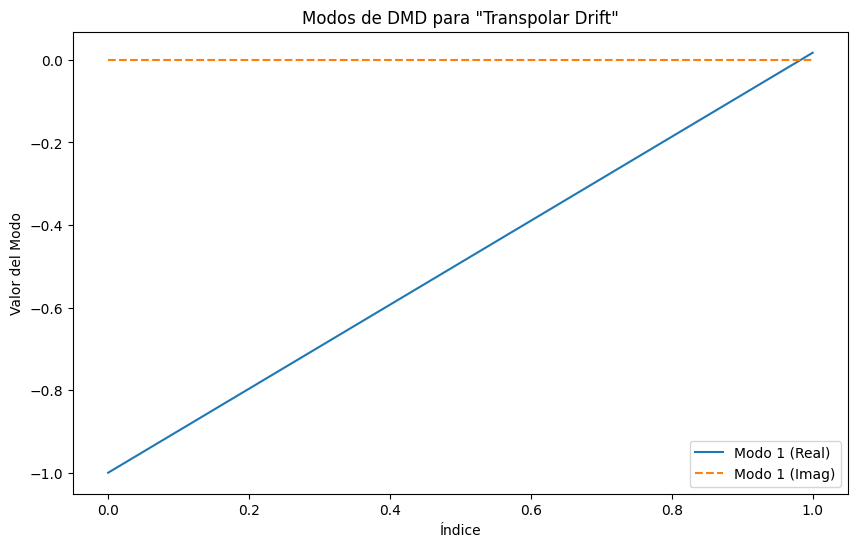

In [19]:

# Graficar los modos
plt.figure(figsize=(10, 6))
for i, mode in enumerate(modes.T):
    plt.plot(mode.real, label=f'Modo {i+1} (Real)')
    plt.plot(mode.imag, linestyle='--', label=f'Modo {i+1} (Imag)')

plt.xlabel('Índice')
plt.ylabel('Valor del Modo')
plt.title('Modos de DMD para "Transpolar Drift"')
plt.legend()
plt.show()

In [16]:
norwegian_filtered_gdf = filtered_gdf_with_temp[filtered_gdf_with_temp['longitude'] == 71.351349]
norwegian_filtered_gdf

longitude   latitude                    geometry  temperature  \
14953  71.351349 -60.272194  POINT (71.35135 -60.27219)     0.216978   

       index_right  OBJECTID Layer  OBJECTID_1  TEMP    SCALE  \
14953           54       128   1pt          23  cold  5000000   

                                       NAME  
14953  East Wind Drift / Antarctic Subpolar

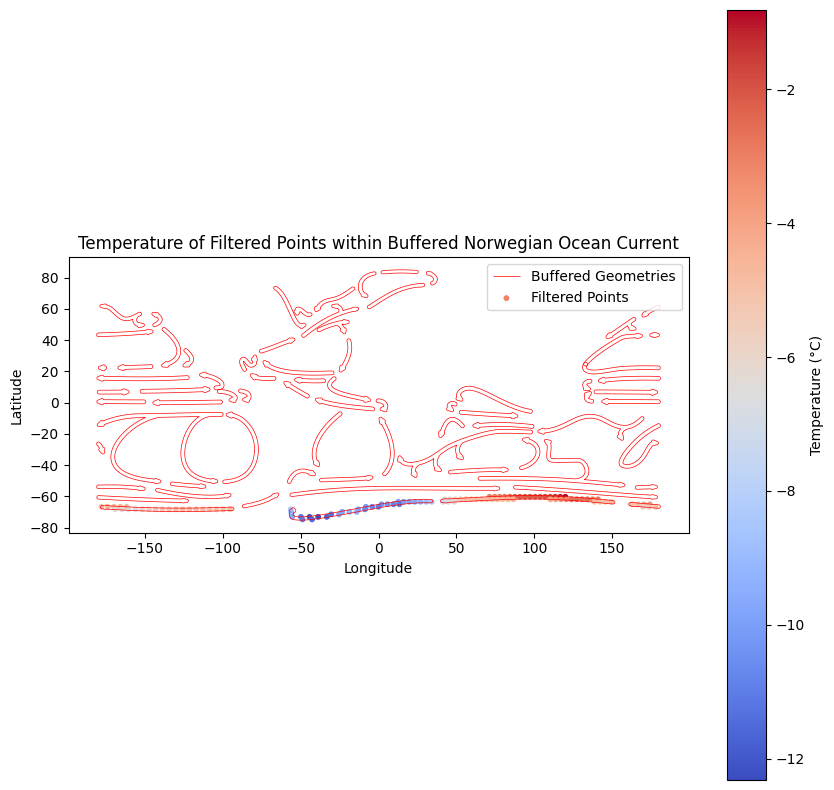

Correlation of climatology with latitude within the Norwegian current: 0.698693912622709


In [3]:
# Filter the points that belong to the Norwegian current
norwegian_filtered_gdf = filtered_gdf_with_temp[filtered_gdf_with_temp['NAME'] == 'East Wind Drift / Antarctic Subpolar']

# Check if there are any points within the Norwegian current
if not norwegian_filtered_gdf.empty:
    # Plot the filtered points for the Norwegian current with temperature
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_temperature(norwegian_filtered_gdf, buffered_gdf, ax)

    # Add legend and titles
    plt.legend()
    plt.title('Temperature of Filtered Points within Buffered Norwegian Ocean Current')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show plot
    plt.show()

    # Calculate the correlation of climatology data with latitude within the Norwegian current
    correlation = norwegian_filtered_gdf['climatology'].corr(norwegian_filtered_gdf['latitude'])
    print(f"Correlation of climatology with latitude within the Norwegian current: {correlation}")

else:
    print("No points found within the Norwegian current.")


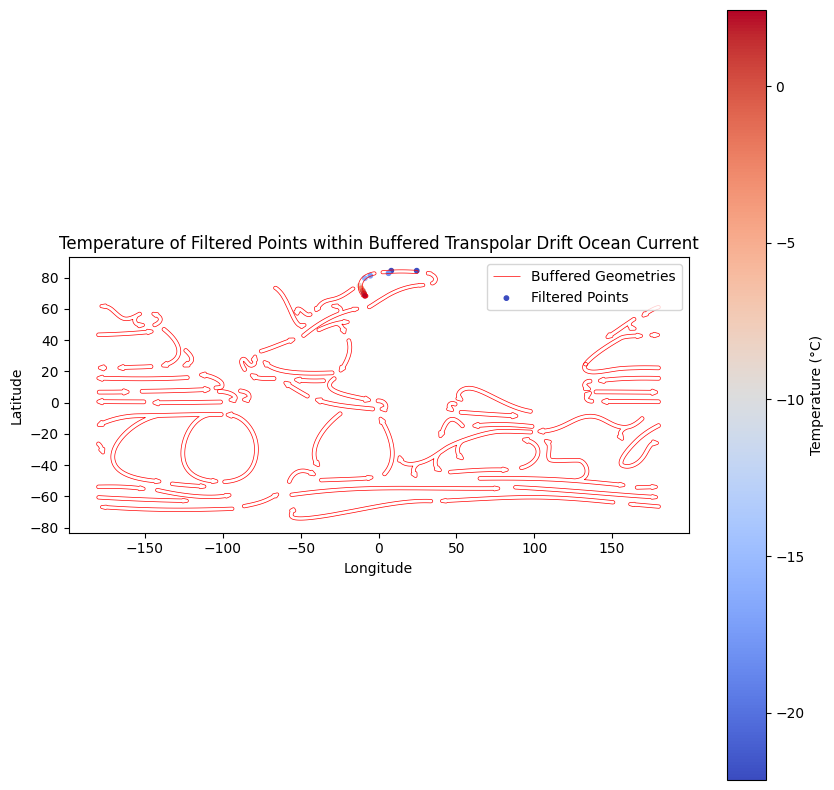

Correlation matrix for the Transpolar Drift current:
             climatology  latitude  longitude
climatology     1.000000 -0.992884  -0.732255
latitude       -0.992884  1.000000   0.756536
longitude      -0.732255  0.756536   1.000000


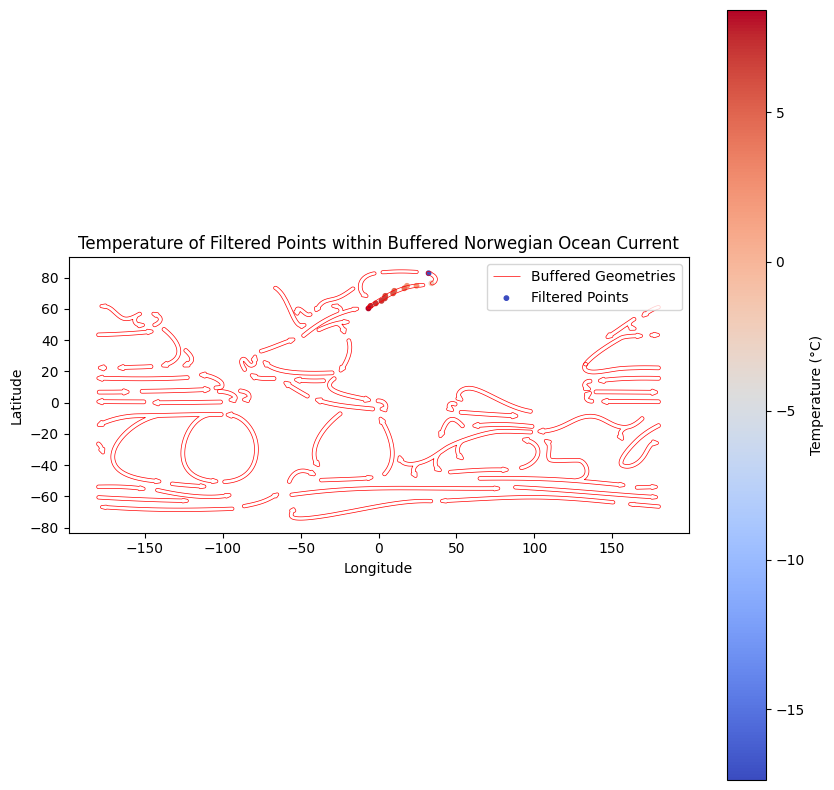

Correlation matrix for the Norwegian current:
             climatology  latitude  longitude
climatology     1.000000 -0.846213  -0.794882
latitude       -0.846213  1.000000   0.957576
longitude      -0.794882  0.957576   1.000000


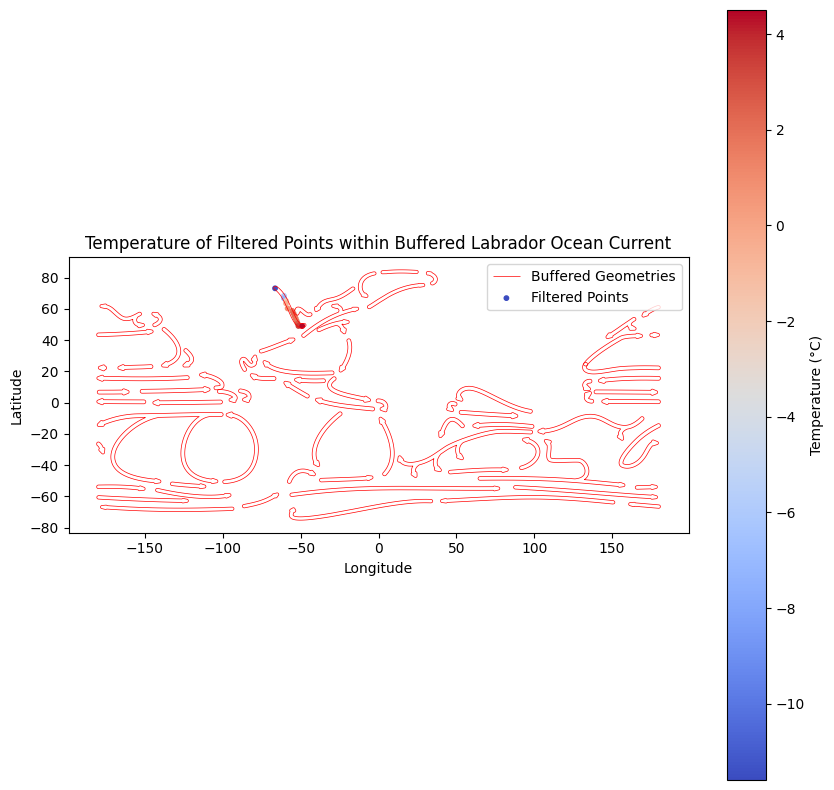

Correlation matrix for the Labrador current:
             climatology  latitude  longitude
climatology     1.000000 -0.917185   0.924161
latitude       -0.917185  1.000000  -0.981364
longitude       0.924161 -0.981364   1.000000


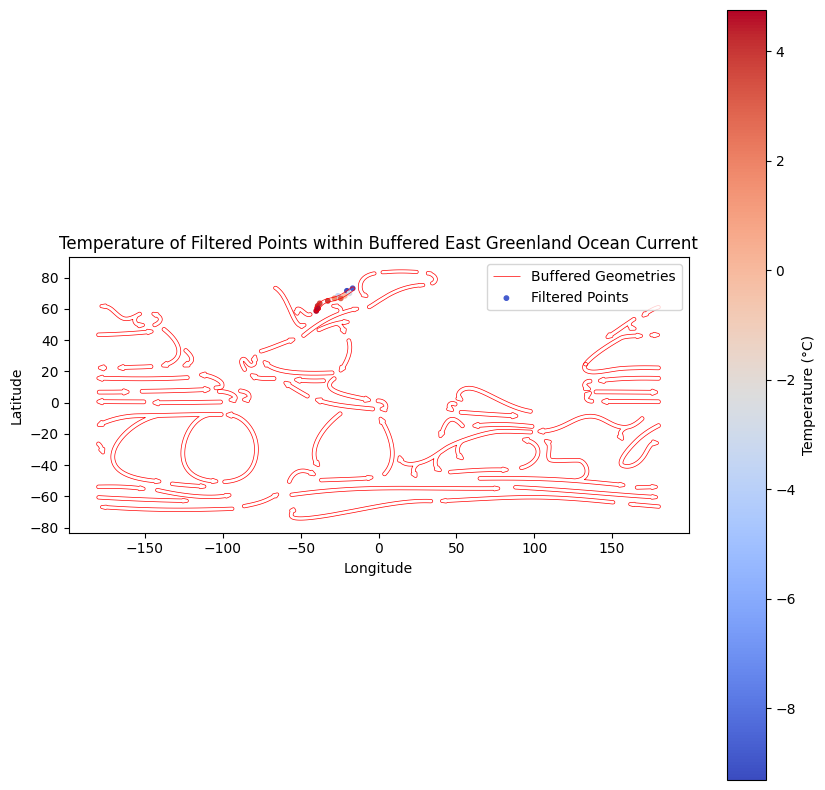

Correlation matrix for the East Greenland current:
             climatology  latitude  longitude
climatology     1.000000 -0.887712  -0.823591
latitude       -0.887712  1.000000   0.957495
longitude      -0.823591  0.957495   1.000000


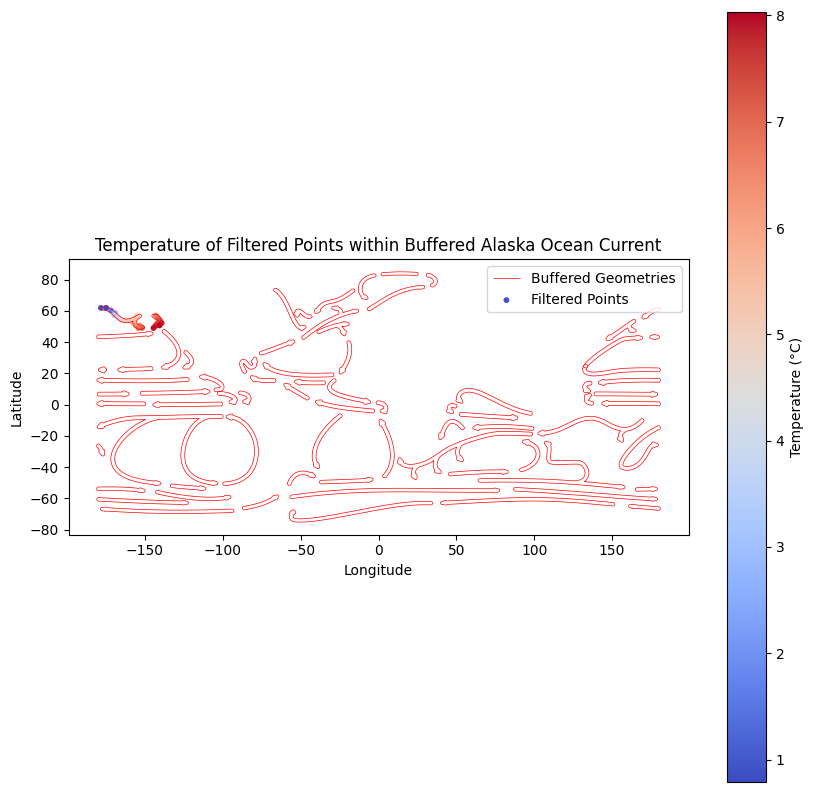

Correlation matrix for the Alaska current:
             climatology  latitude  longitude
climatology     1.000000 -0.865504   0.942609
latitude       -0.865504  1.000000  -0.667546
longitude       0.942609 -0.667546   1.000000


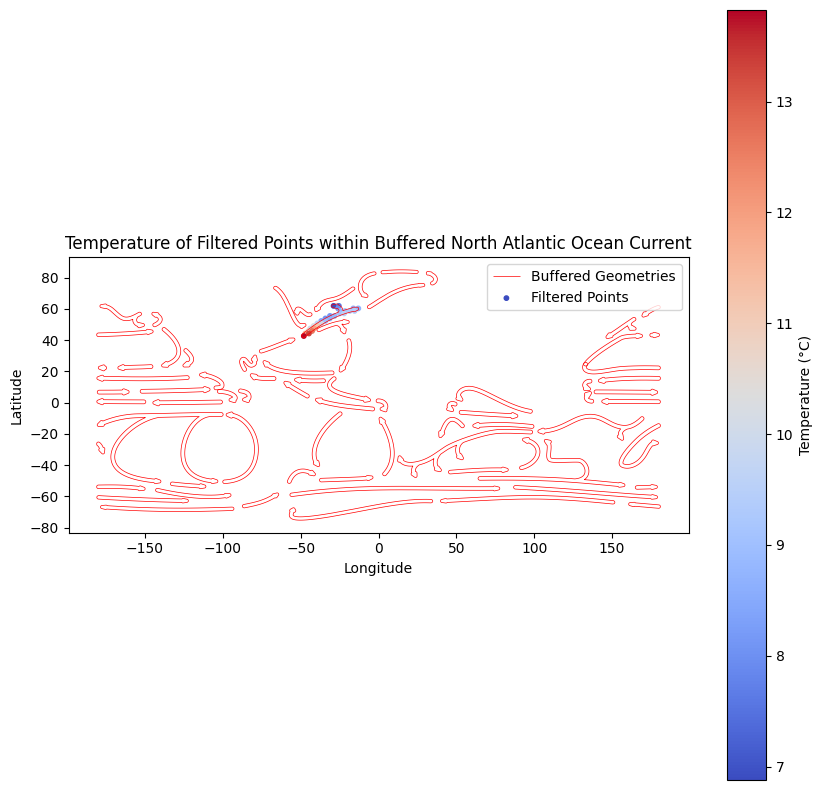

Correlation matrix for the North Atlantic current:
             climatology  latitude  longitude
climatology     1.000000 -0.854737  -0.662260
latitude       -0.854737  1.000000   0.921133
longitude      -0.662260  0.921133   1.000000


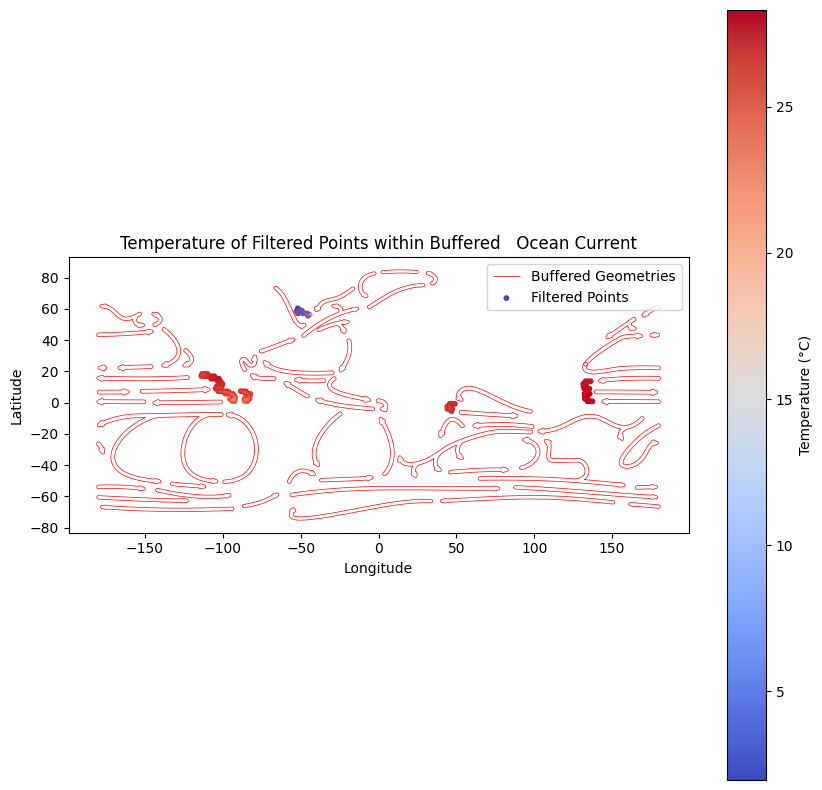

Correlation matrix for the   current:
             climatology  latitude  longitude
climatology     1.000000 -0.877291   0.203363
latitude       -0.877291  1.000000  -0.181884
longitude       0.203363 -0.181884   1.000000


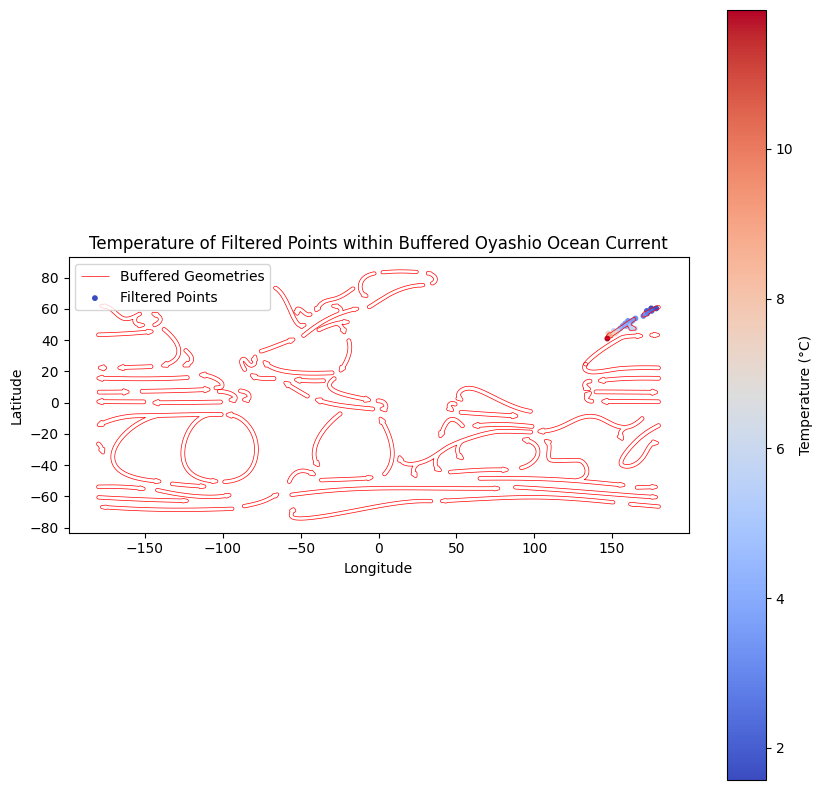

Correlation matrix for the Oyashio current:
             climatology  latitude  longitude
climatology     1.000000 -0.894471  -0.826803
latitude       -0.894471  1.000000   0.955278
longitude      -0.826803  0.955278   1.000000


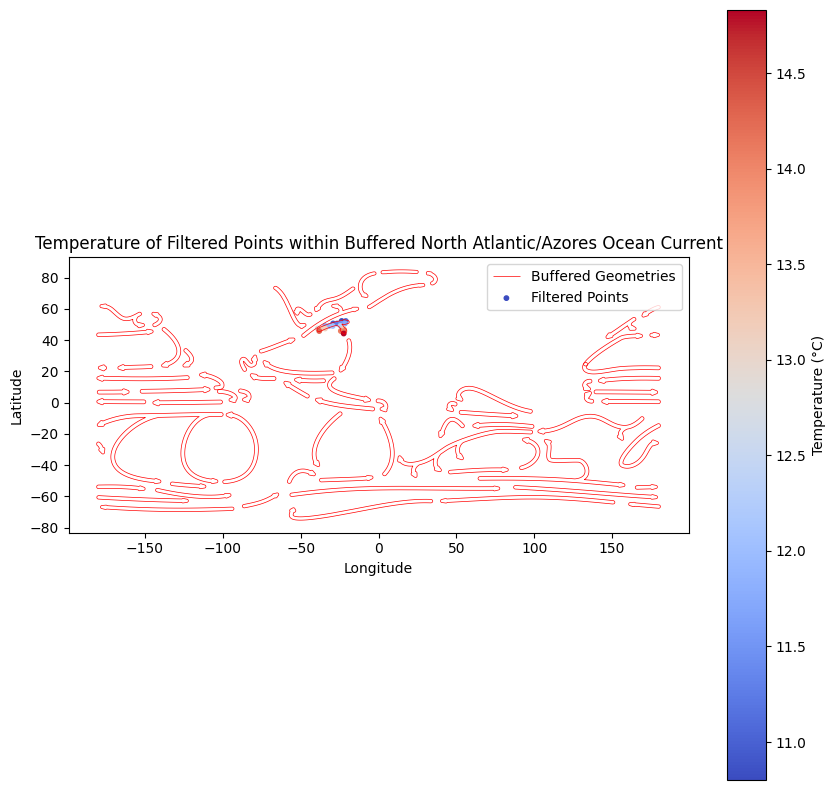

Correlation matrix for the North Atlantic/Azores current:
             climatology  latitude  longitude
climatology     1.000000 -0.972553  -0.140325
latitude       -0.972553  1.000000   0.243508
longitude      -0.140325  0.243508   1.000000


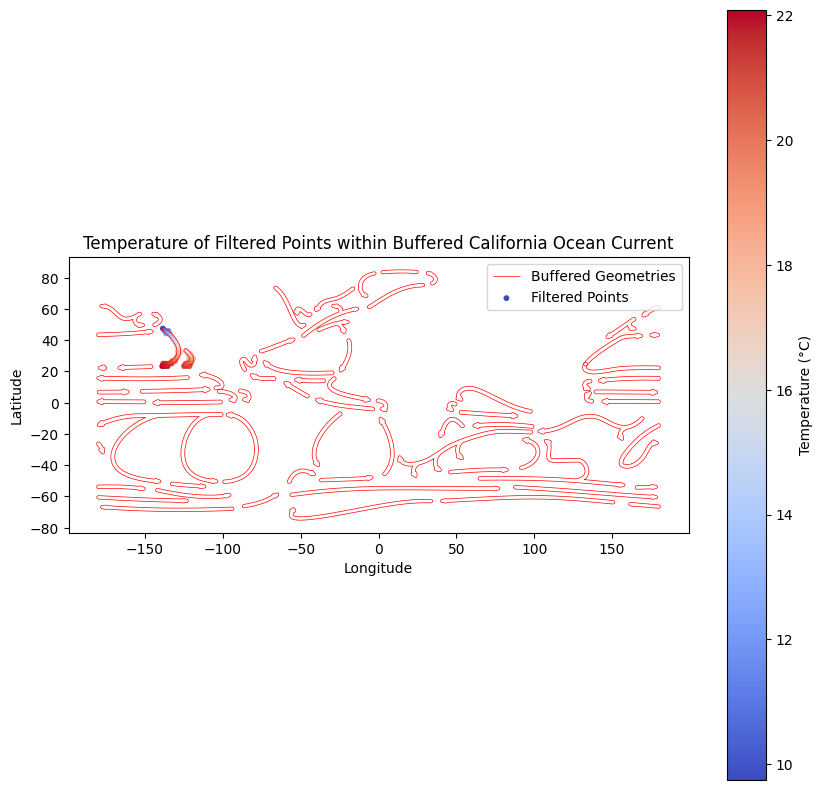

Correlation matrix for the California current:
             climatology  latitude  longitude
climatology     1.000000 -0.976762   0.184315
latitude       -0.976762  1.000000  -0.349032
longitude       0.184315 -0.349032   1.000000


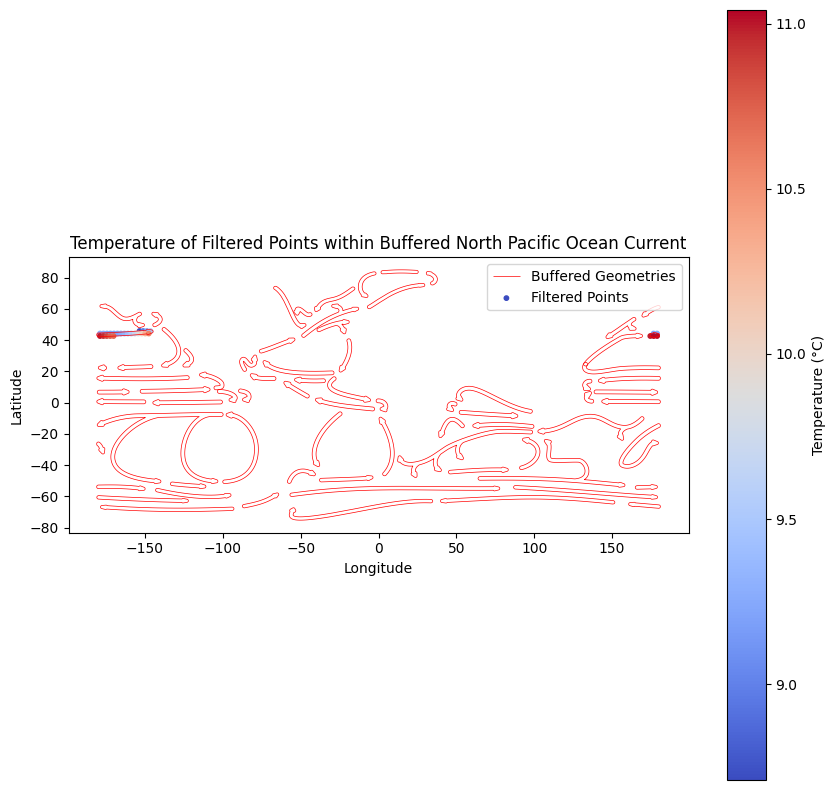

Correlation matrix for the North Pacific current:
             climatology  latitude  longitude
climatology     1.000000 -0.835669   0.260837
latitude       -0.835669  1.000000  -0.287668
longitude       0.260837 -0.287668   1.000000


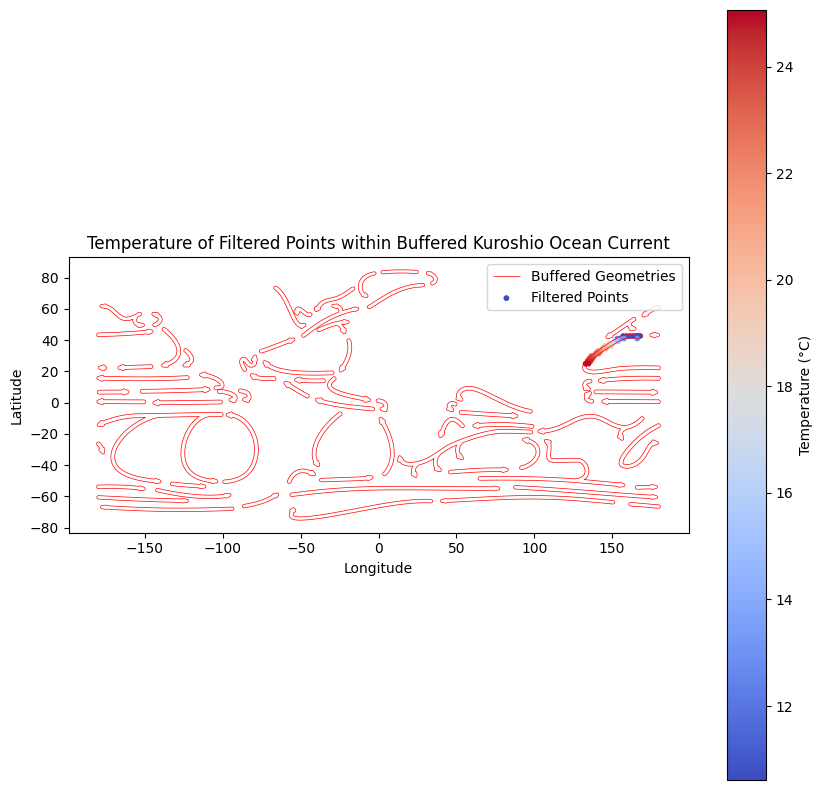

Correlation matrix for the Kuroshio current:
             climatology  latitude  longitude
climatology     1.000000 -0.970248  -0.964849
latitude       -0.970248  1.000000   0.950642
longitude      -0.964849  0.950642   1.000000


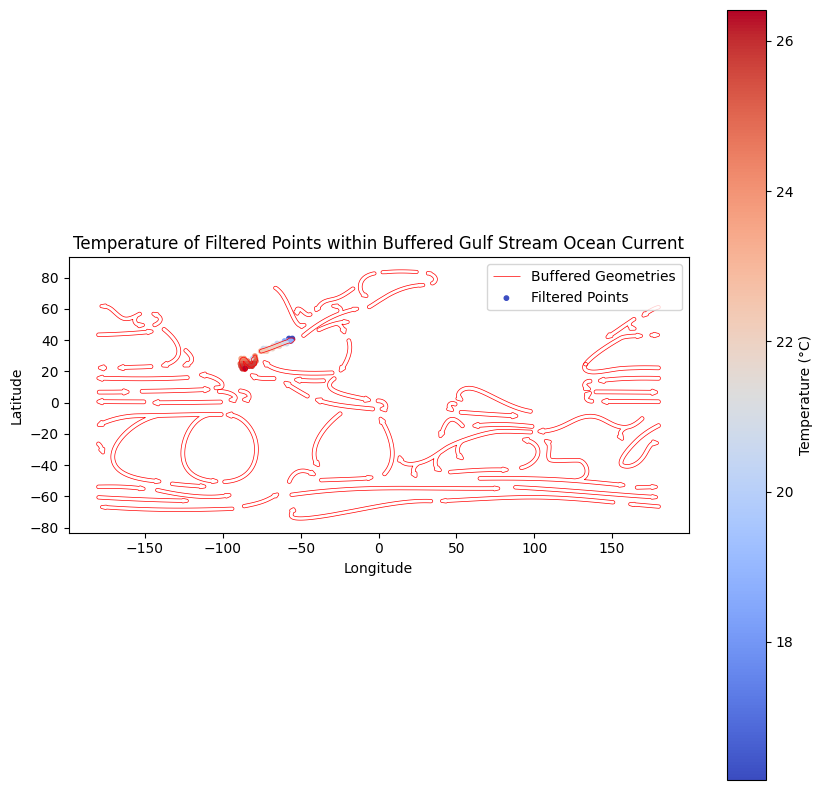

Correlation matrix for the Gulf Stream current:
             climatology  latitude  longitude
climatology     1.000000 -0.920090  -0.870577
latitude       -0.920090  1.000000   0.947238
longitude      -0.870577  0.947238   1.000000


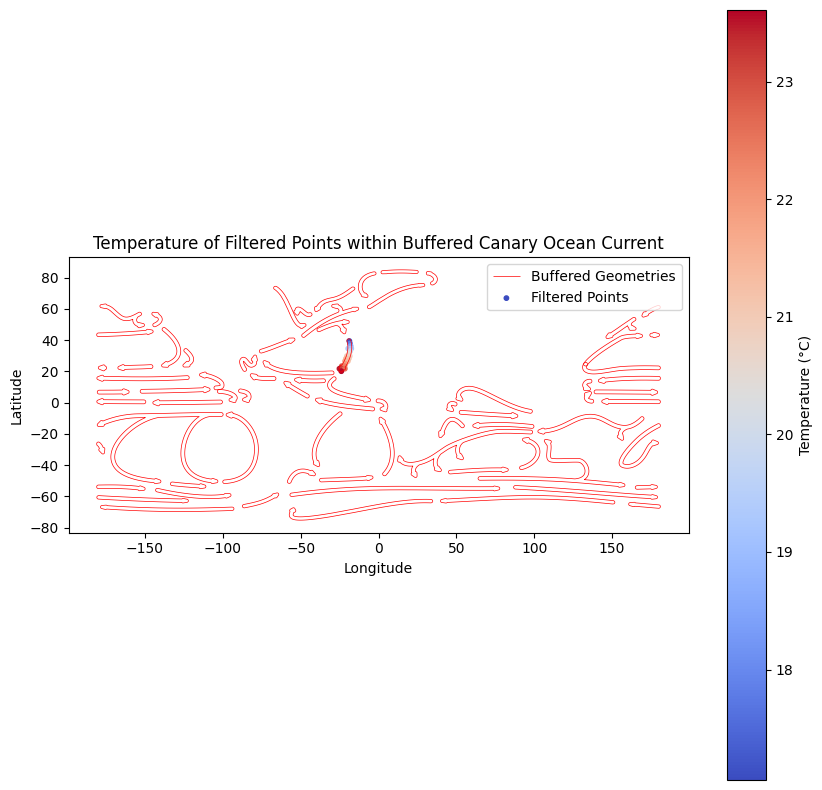

Correlation matrix for the Canary current:
             climatology  latitude  longitude
climatology     1.000000 -0.988241  -0.865998
latitude       -0.988241  1.000000   0.862765
longitude      -0.865998  0.862765   1.000000


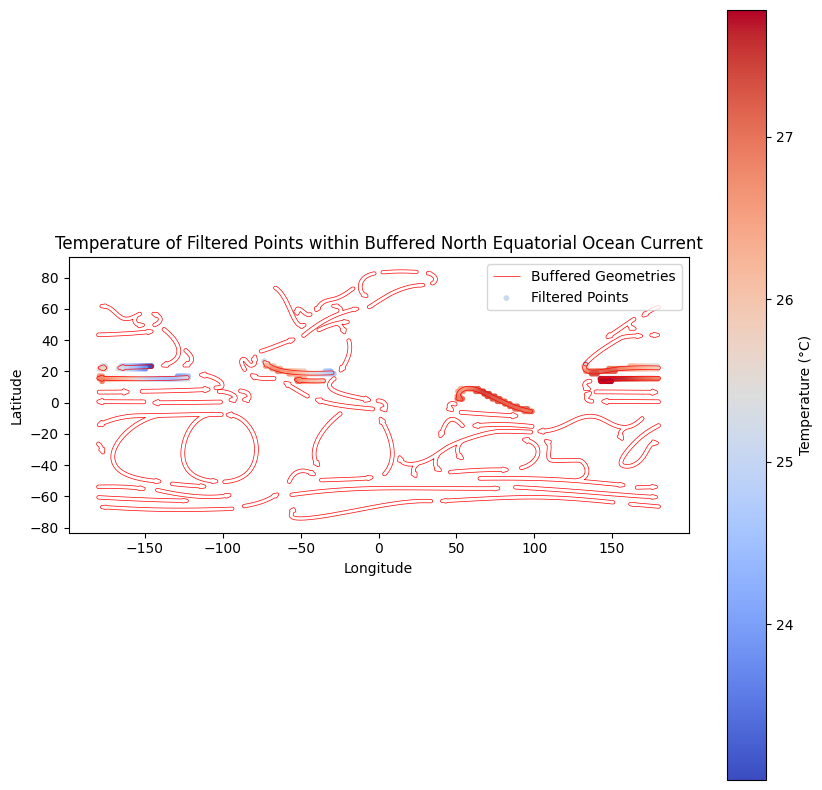

Correlation matrix for the North Equatorial current:
             climatology  latitude  longitude
climatology     1.000000  -0.48011   0.654545
latitude       -0.480110   1.00000  -0.204960
longitude       0.654545  -0.20496   1.000000


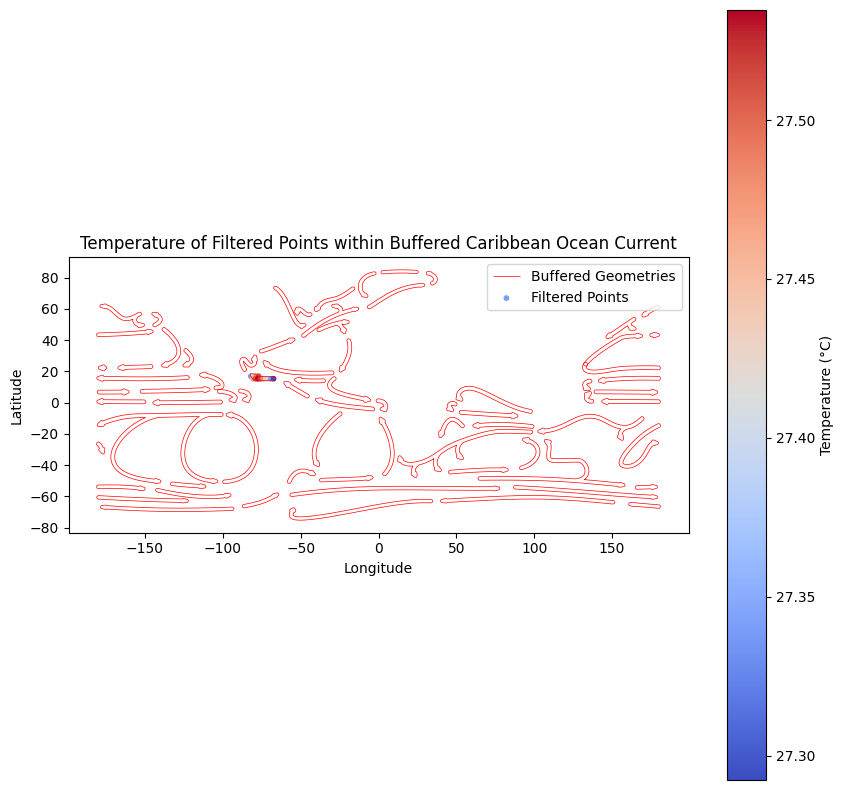

Correlation matrix for the Caribbean current:
             climatology  latitude  longitude
climatology     1.000000 -0.027290  -0.454801
latitude       -0.027290  1.000000  -0.553498
longitude      -0.454801 -0.553498   1.000000


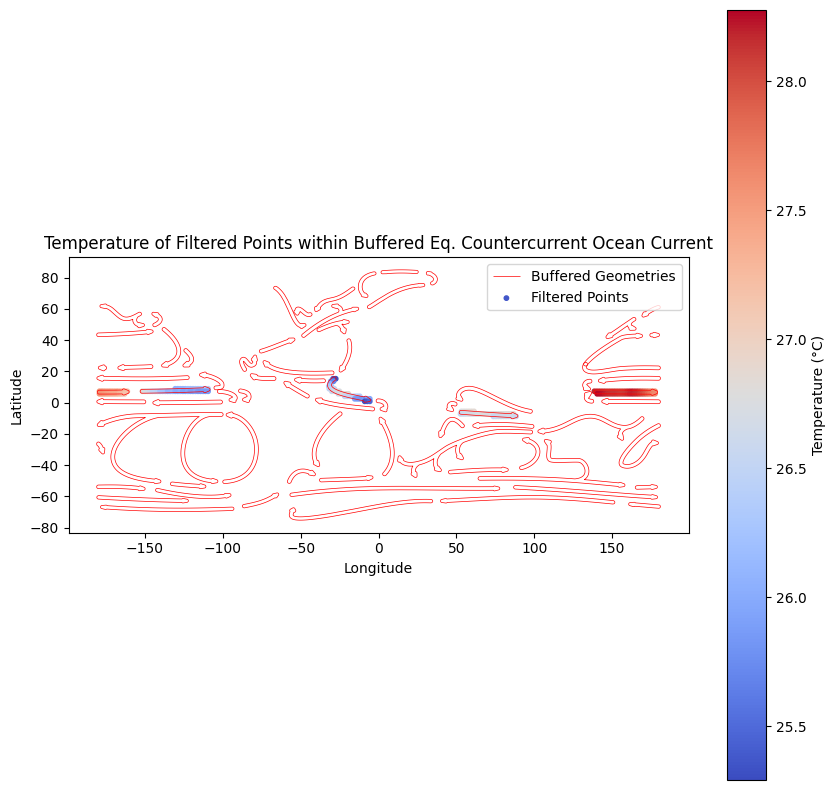

Correlation matrix for the Eq. Countercurrent current:
             climatology  latitude  longitude
climatology     1.000000  0.088923   0.562010
latitude        0.088923  1.000000  -0.317096
longitude       0.562010 -0.317096   1.000000


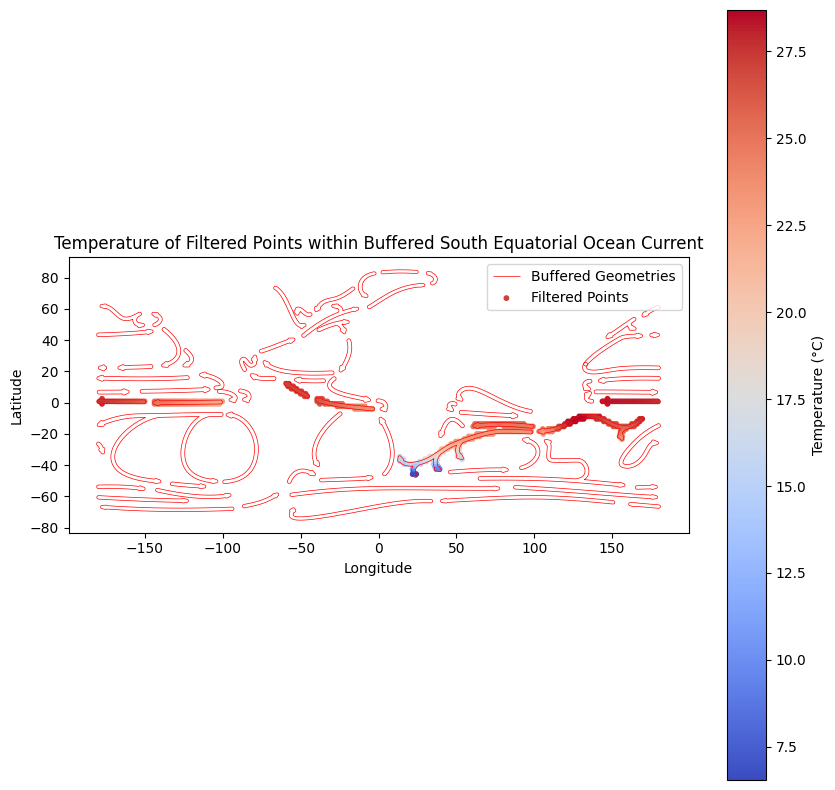

Correlation matrix for the South Equatorial current:
             climatology  latitude  longitude
climatology     1.000000  0.756749   0.132122
latitude        0.756749  1.000000  -0.402707
longitude       0.132122 -0.402707   1.000000


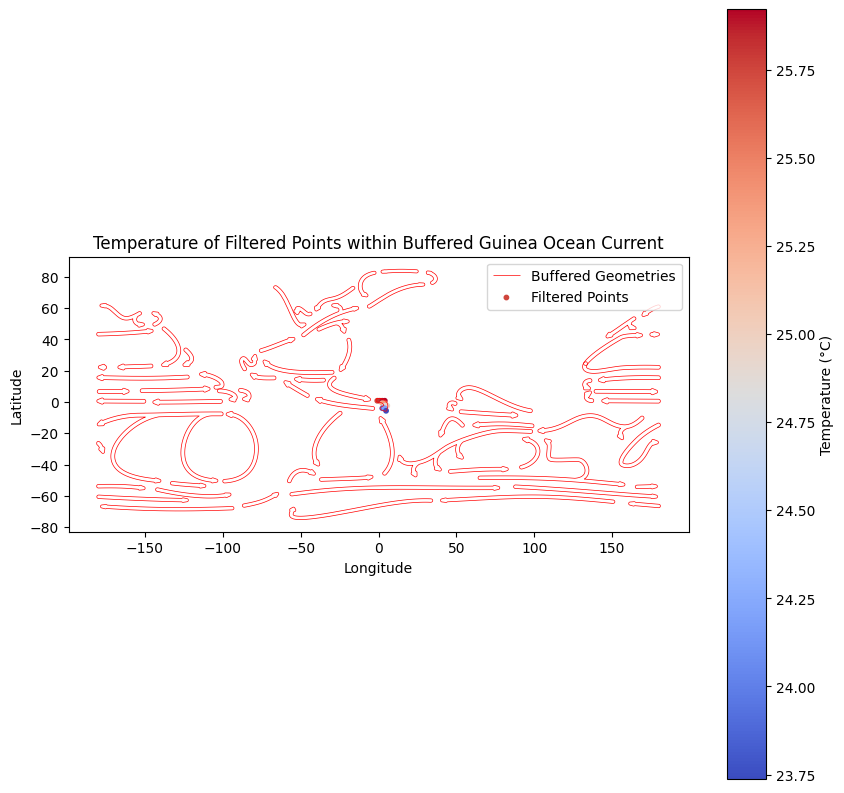

Correlation matrix for the Guinea current:
             climatology  latitude  longitude
climatology     1.000000  0.991205  -0.471813
latitude        0.991205  1.000000  -0.568424
longitude      -0.471813 -0.568424   1.000000


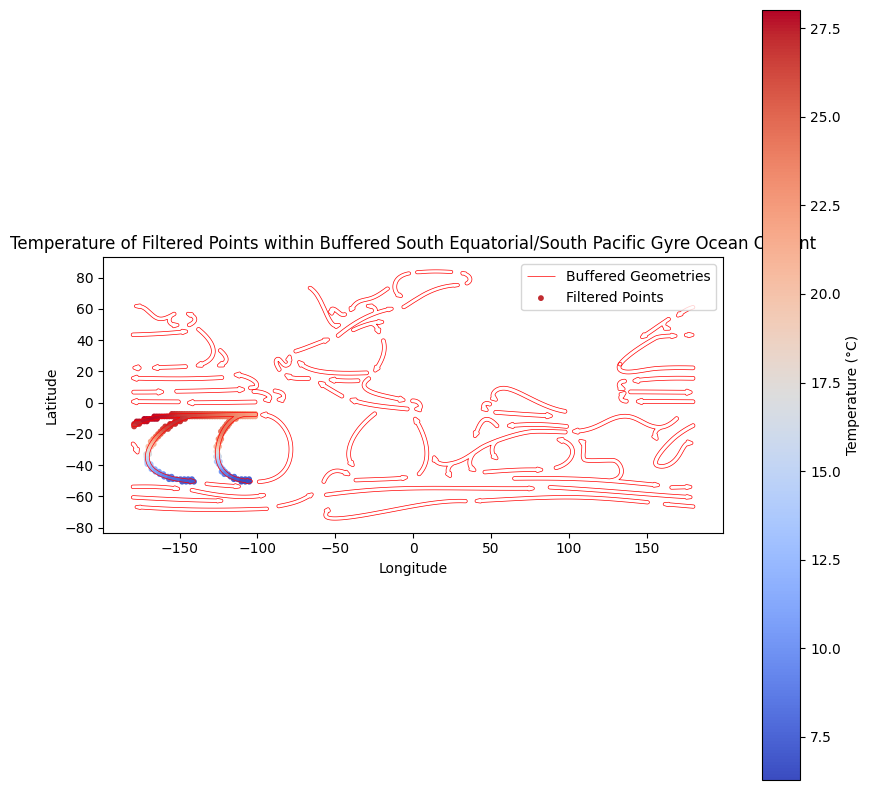

Correlation matrix for the South Equatorial/South Pacific Gyre current:
             climatology  latitude  longitude
climatology     1.000000  0.947298  -0.168880
latitude        0.947298  1.000000   0.061542
longitude      -0.168880  0.061542   1.000000


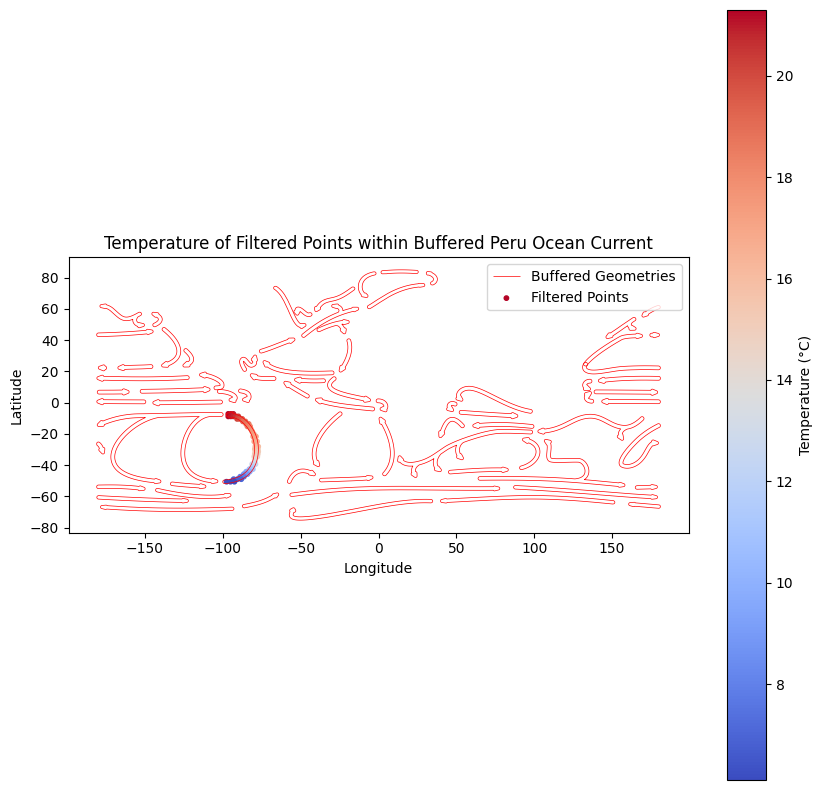

Correlation matrix for the Peru current:
             climatology  latitude  longitude
climatology     1.000000  0.974816  -0.001674
latitude        0.974816  1.000000  -0.166476
longitude      -0.001674 -0.166476   1.000000


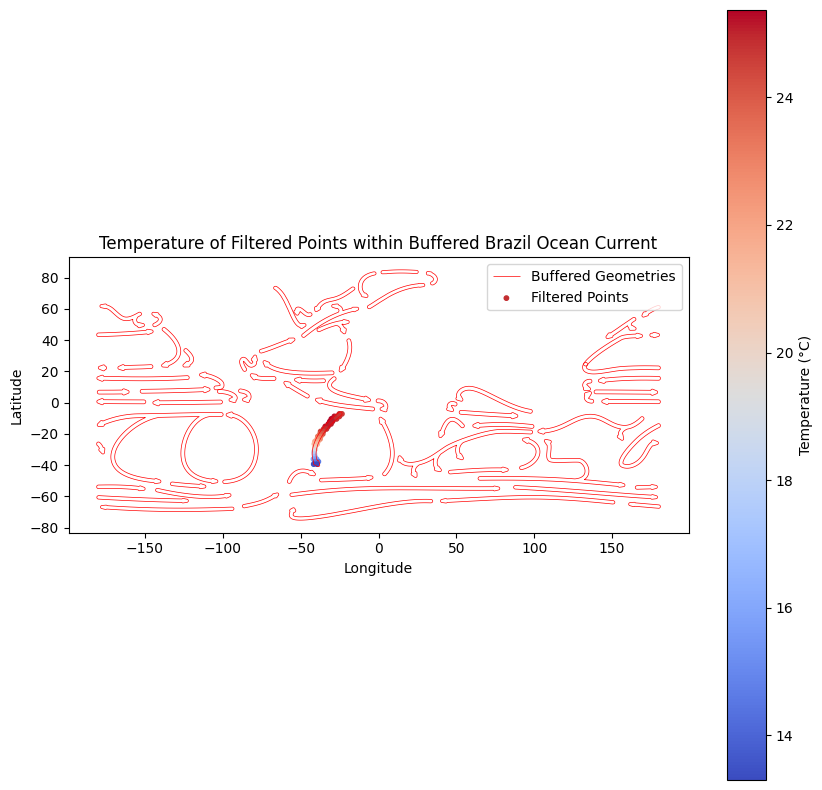

Correlation matrix for the Brazil current:
             climatology  latitude  longitude
climatology     1.000000  0.941103   0.702282
latitude        0.941103  1.000000   0.894237
longitude       0.702282  0.894237   1.000000


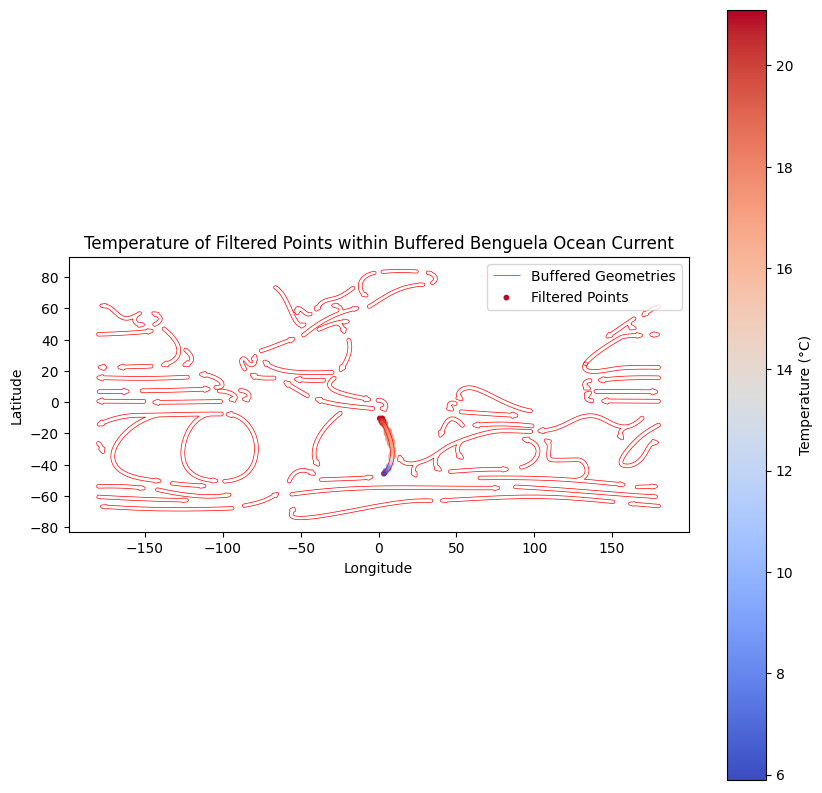

Correlation matrix for the Benguela current:
             climatology  latitude  longitude
climatology     1.000000  0.925193  -0.257077
latitude        0.925193  1.000000  -0.531951
longitude      -0.257077 -0.531951   1.000000


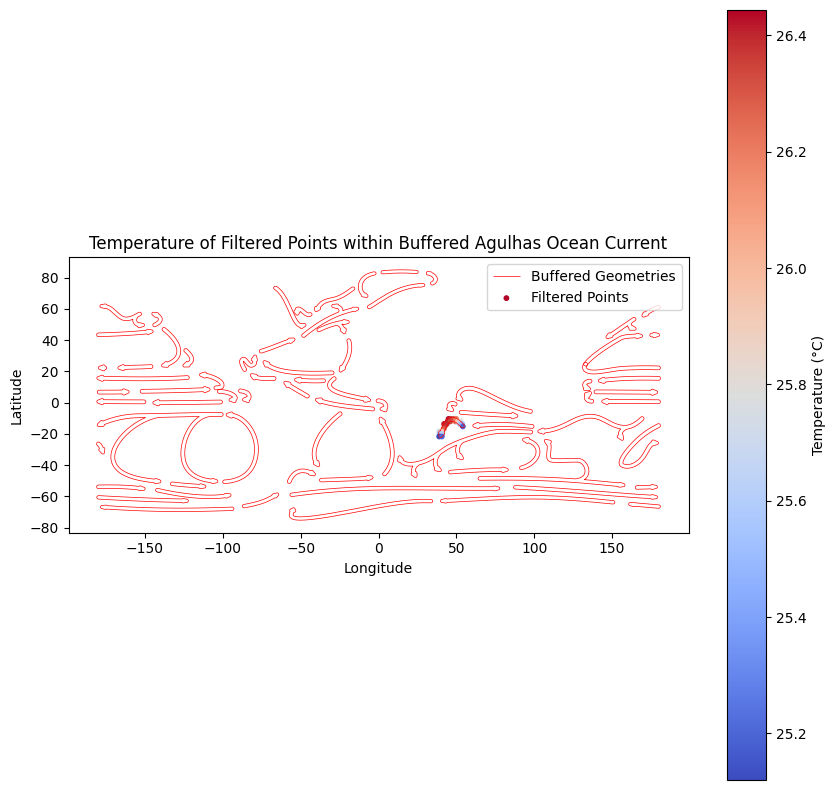

Correlation matrix for the Agulhas current:
             climatology  latitude  longitude
climatology     1.000000  0.690253  -0.007983
latitude        0.690253  1.000000   0.672295
longitude      -0.007983  0.672295   1.000000


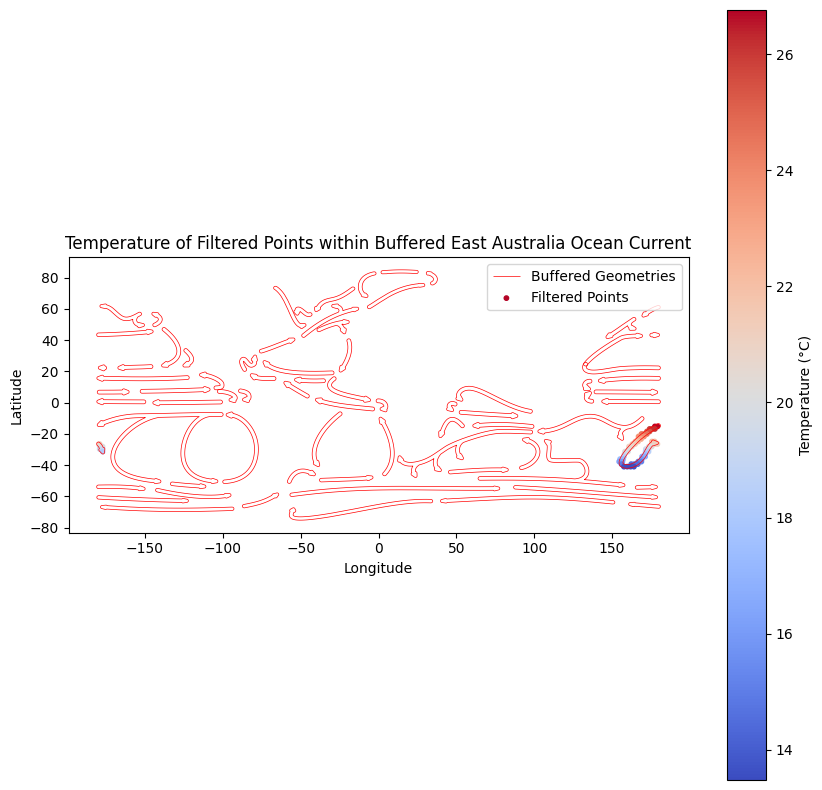

Correlation matrix for the East Australia current:
             climatology  latitude  longitude
climatology     1.000000  0.991952   0.066051
latitude        0.991952  1.000000   0.034935
longitude       0.066051  0.034935   1.000000


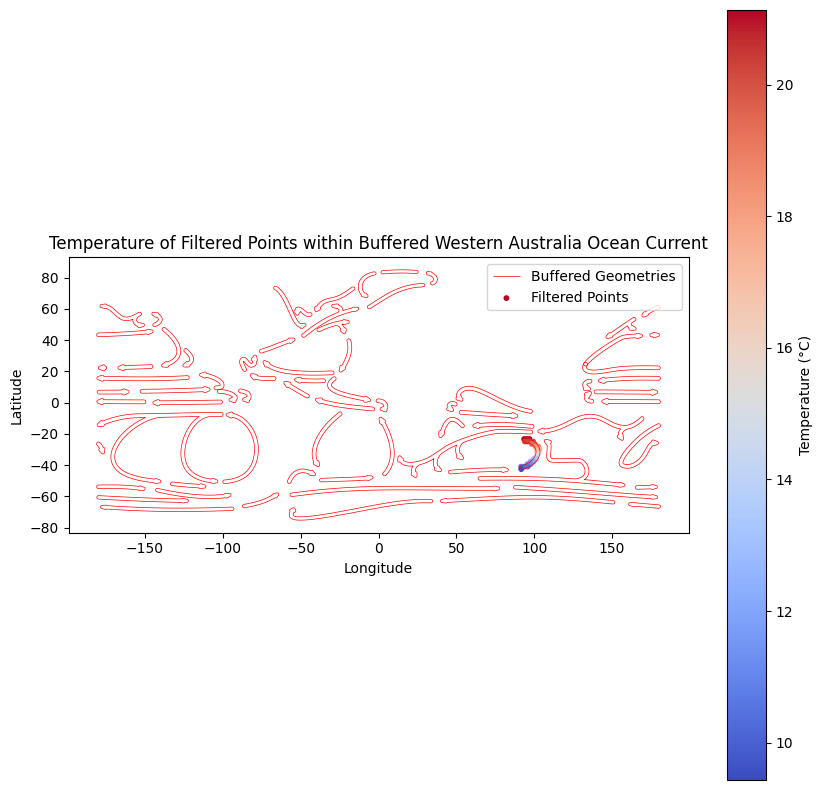

Correlation matrix for the Western Australia current:
             climatology  latitude  longitude
climatology     1.000000  0.999155   0.227573
latitude        0.999155  1.000000   0.205014
longitude       0.227573  0.205014   1.000000


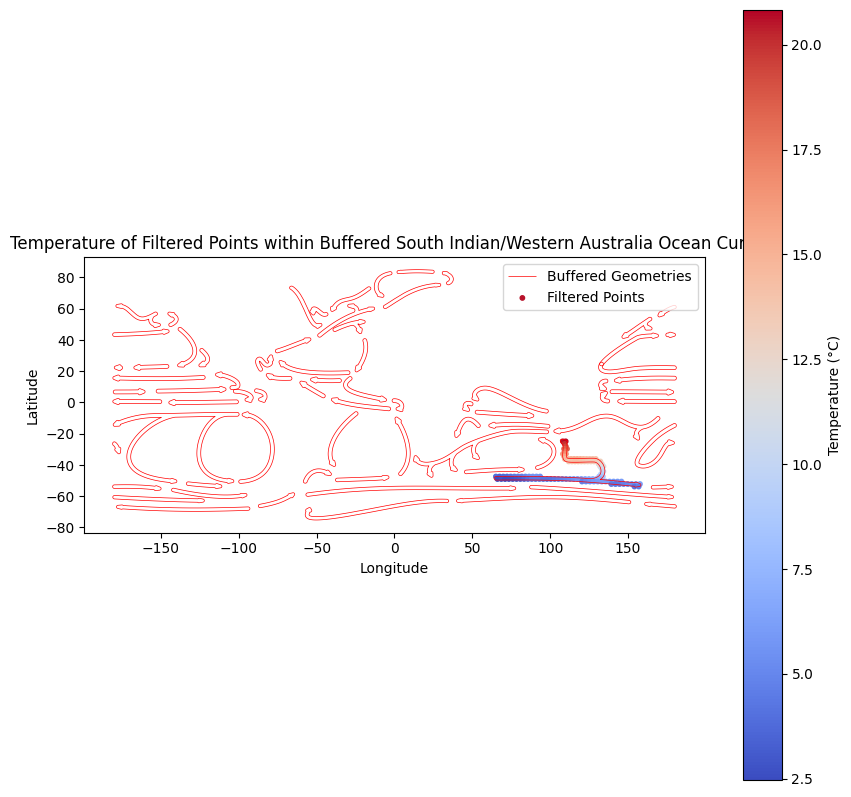

Correlation matrix for the South Indian/Western Australia current:
             climatology  latitude  longitude
climatology     1.000000  0.957549   0.249920
latitude        0.957549  1.000000  -0.021475
longitude       0.249920 -0.021475   1.000000


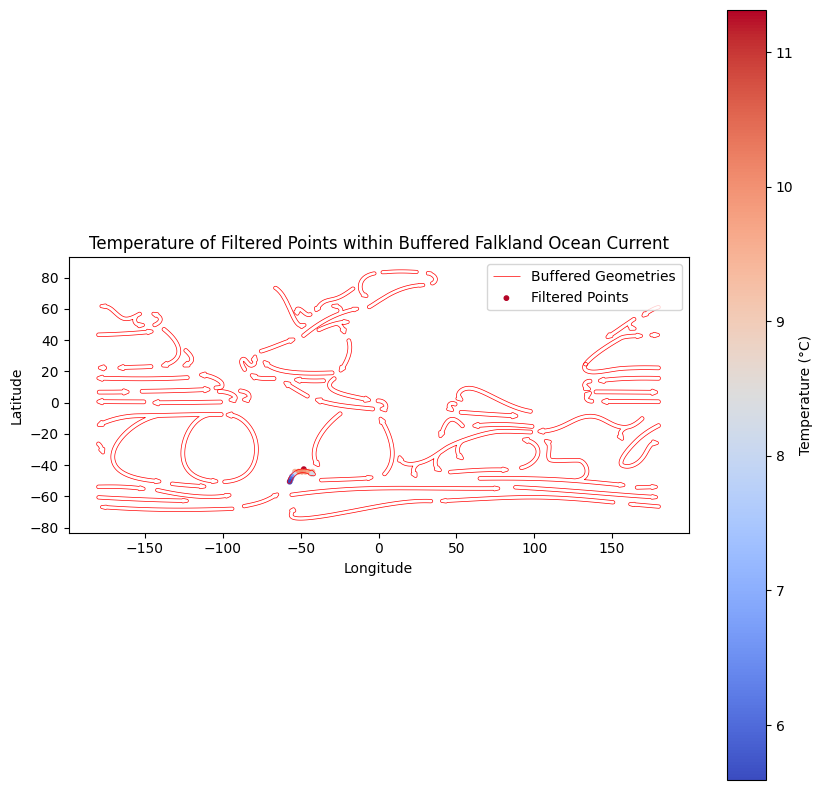

Correlation matrix for the Falkland current:
             climatology  latitude  longitude
climatology     1.000000  0.976523   0.625542
latitude        0.976523  1.000000   0.650672
longitude       0.625542  0.650672   1.000000


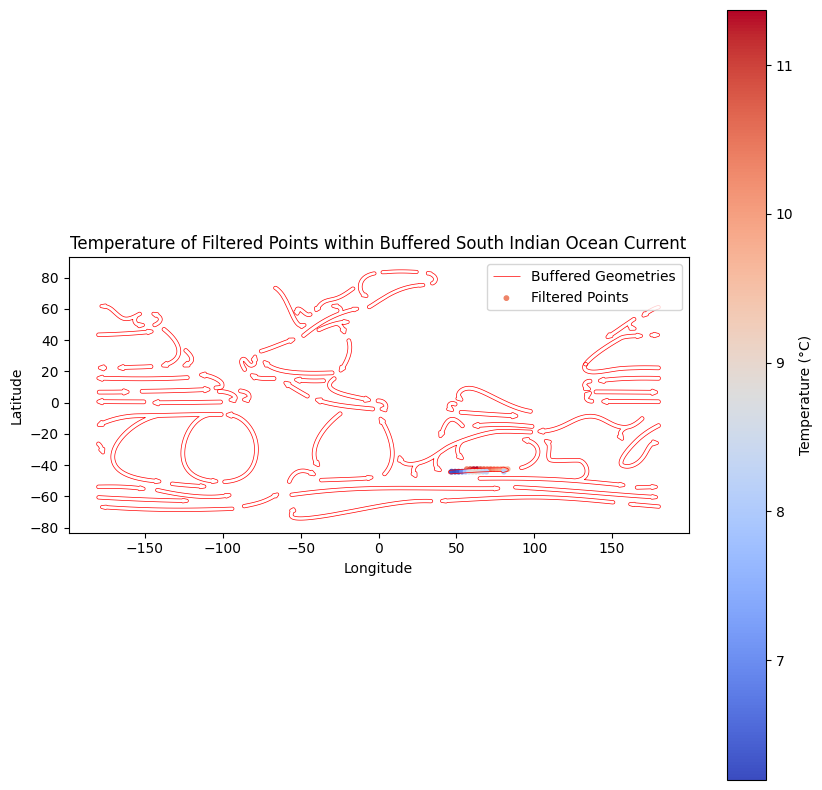

Correlation matrix for the South Indian current:
             climatology  latitude  longitude
climatology     1.000000  0.852063   0.498264
latitude        0.852063  1.000000   0.492869
longitude       0.498264  0.492869   1.000000


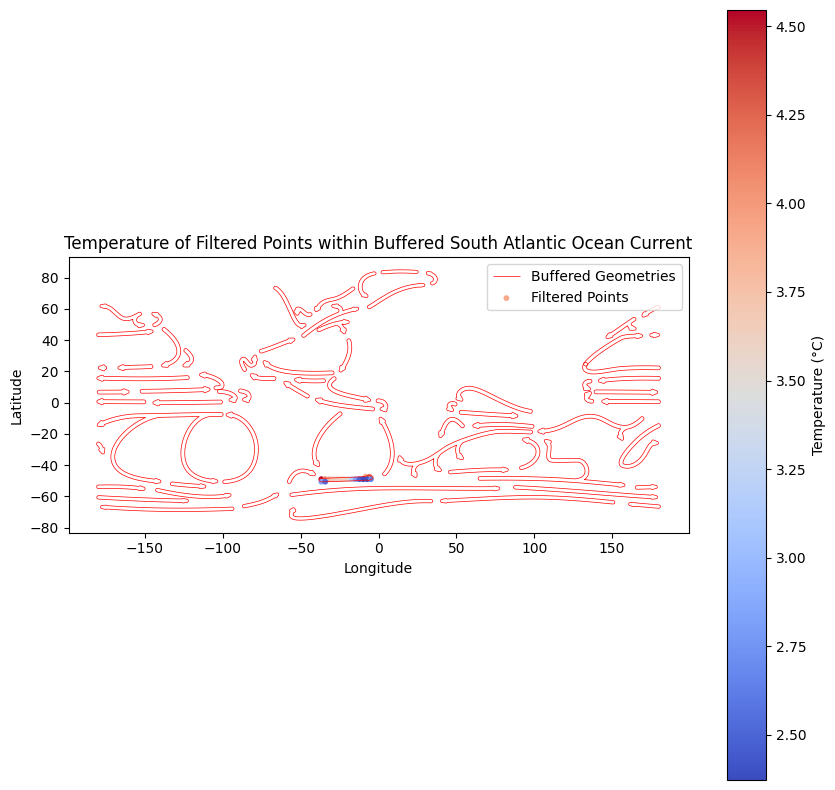

Correlation matrix for the South Atlantic current:
             climatology  latitude  longitude
climatology     1.000000  0.482755  -0.363578
latitude        0.482755  1.000000   0.608397
longitude      -0.363578  0.608397   1.000000


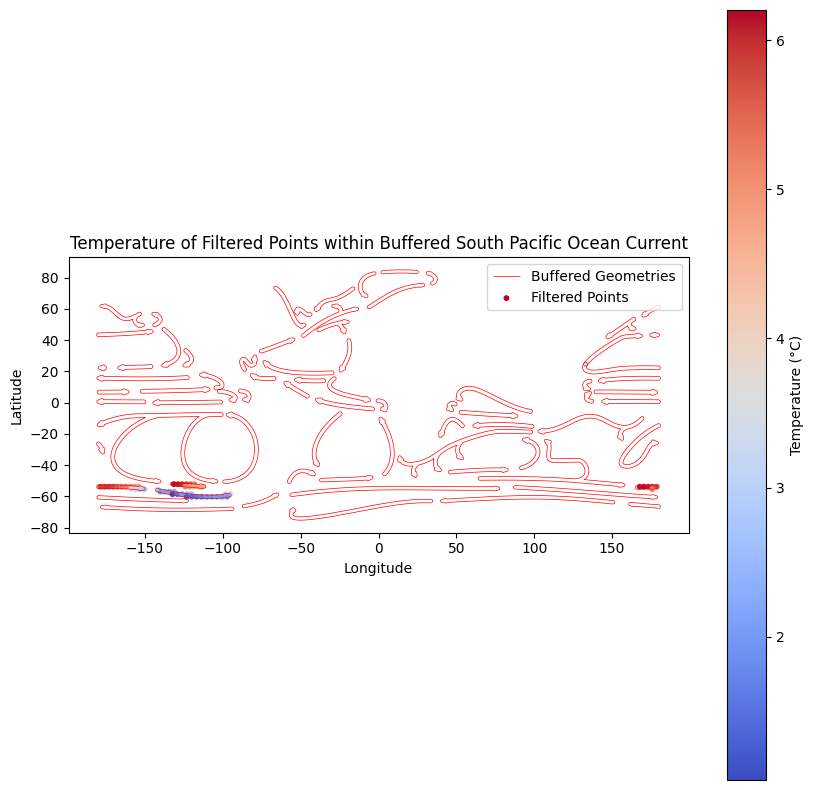

Correlation matrix for the South Pacific current:
             climatology  latitude  longitude
climatology     1.000000  0.920891   0.298401
latitude        0.920891  1.000000   0.112614
longitude       0.298401  0.112614   1.000000


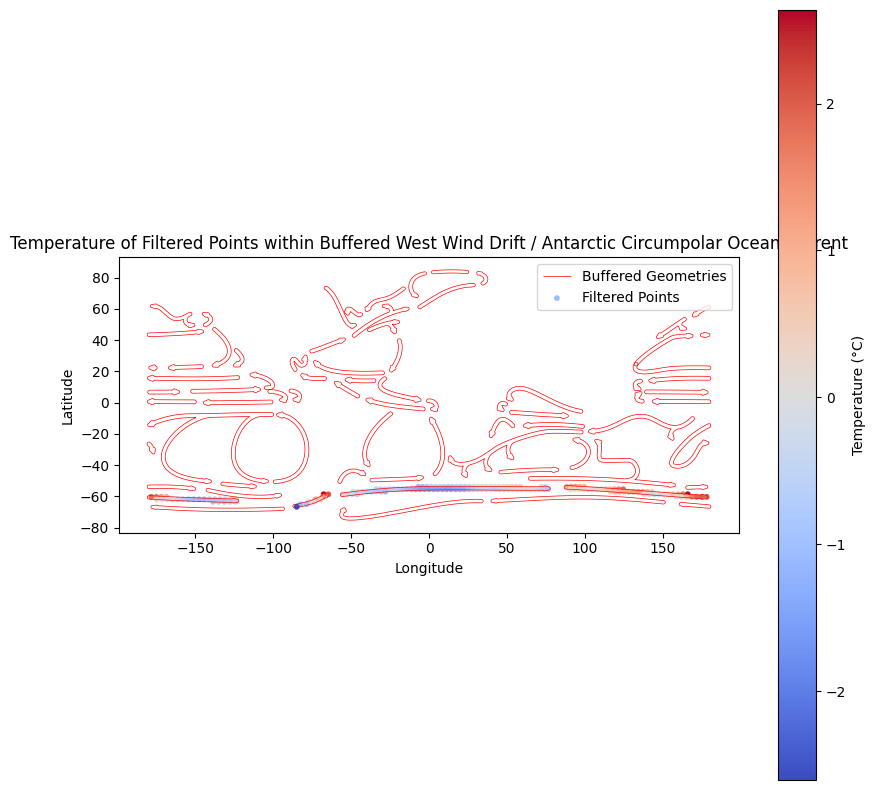

Correlation matrix for the West Wind Drift / Antarctic Circumpolar current:
             climatology  latitude  longitude
climatology     1.000000 -0.028386   0.394400
latitude       -0.028386  1.000000   0.506794
longitude       0.394400  0.506794   1.000000


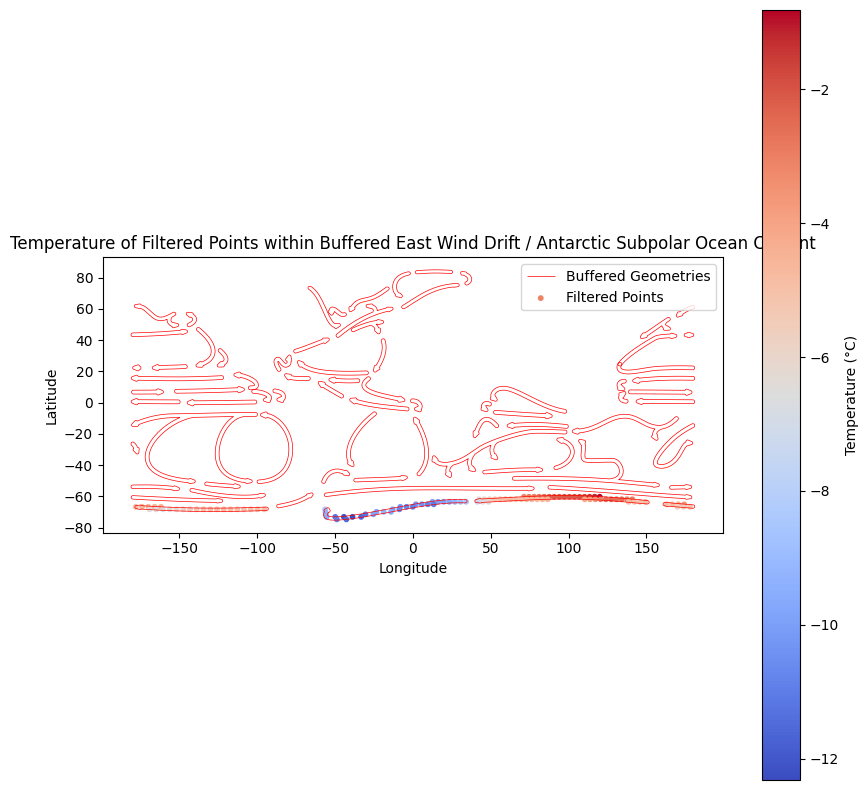

Correlation matrix for the East Wind Drift / Antarctic Subpolar current:
             climatology  latitude  longitude
climatology     1.000000  0.698694   0.379277
latitude        0.698694  1.000000   0.658518
longitude       0.379277  0.658518   1.000000

Transpolar Drift current correlation matrix:
             climatology  latitude  longitude
climatology     1.000000 -0.992884  -0.732255
latitude       -0.992884  1.000000   0.756536
longitude      -0.732255  0.756536   1.000000

Norwegian current correlation matrix:
             climatology  latitude  longitude
climatology     1.000000 -0.846213  -0.794882
latitude       -0.846213  1.000000   0.957576
longitude      -0.794882  0.957576   1.000000

Labrador current correlation matrix:
             climatology  latitude  longitude
climatology     1.000000 -0.917185   0.924161
latitude       -0.917185  1.000000  -0.981364
longitude       0.924161 -0.981364   1.000000

East Greenland current correlation matrix:
             climatology

In [4]:
# Define a function to plot the temperature of filtered points
def plot_temperature(filtered_gdf, buffered_gdf, ax, title):
    buffered_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5, label='Buffered Geometries')
    
    scatter = ax.scatter(
        filtered_gdf.geometry.x, 
        filtered_gdf.geometry.y, 
        c=filtered_gdf['climatology'], 
        cmap='coolwarm', 
        s=10, 
        label='Filtered Points'
    )
    plt.colorbar(scatter, ax=ax, label='Temperature (°C)')
    
    # Add legend and titles
    plt.legend()
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

# Get the unique ocean current names
unique_currents = filtered_gdf_with_temp['NAME'].unique()

# Create a dictionary to store the correlation matrices for each current
correlation_matrices = {}

# Iterate through each unique ocean current
for current in unique_currents:
    current_filtered_gdf = filtered_gdf_with_temp[filtered_gdf_with_temp['NAME'] == current]
    
    if not current_filtered_gdf.empty:
        # Create the plot for the current
        fig, ax = plt.subplots(figsize=(10, 10))
        plot_temperature(current_filtered_gdf, buffered_gdf, ax, f'Temperature of Filtered Points within Buffered {current} Ocean Current')
        
        # Show plot
        plt.show()
        
        # Calculate the correlation matrix for climatology, latitude, and longitude
        correlation_matrix = current_filtered_gdf[['climatology', 'latitude', 'longitude']].corr()
        correlation_matrices[current] = correlation_matrix
        print(f"Correlation matrix for the {current} current:")
        print(correlation_matrix)

# Display the correlation matrices
for current, corr_matrix in correlation_matrices.items():
    print(f"\n{current} current correlation matrix:")
    print(corr_matrix)
